In [1]:
# @link https://towardsdatascience.com/from-ml-model-to-ml-pipeline-9f95c32c6512
# Data manipulation
from seaborn import load_dataset
import numpy as np
import pandas as pd
pd.options.display.precision = 4
pd.options.mode.chained_assignment = None  

# Machine learning pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import set_config
set_config(display="diagram")

# Load data
columns = ['alive', 'class', 'embarked', 'who', 'alone', 'adult_male']
df = load_dataset('titanic').drop(columns=columns)
df['deck'] = df['deck'].astype('object')
print(df.shape)
df.head()

(891, 9)


,survived,pclass,sex,age,sibsp,parch,fare,deck,embark_town
0,0,3,male,22.0,1,0,7.2500,NaN,Southampton
1,1,1,female,38.0,1,0,71.2833,C,Cherbourg
2,1,3,female,26.0,0,0,7.9250,NaN,Southampton
3,1,1,female,35.0,1,0,53.1000,C,Southampton
4,0,3,male,35.0,0,0,8.0500,NaN,Southampton


In [116]:
SEED = 42
TARGET = 'survived'
FEATURES = df.columns.drop(TARGET)

NUMERICAL = df[FEATURES].select_dtypes('number').columns
print(f"Numerical features: {', '.join(NUMERICAL)}")

CATEGORICAL = pd.Index(np.setdiff1d(FEATURES, NUMERICAL))
print(f"Categorical features: {', '.join(CATEGORICAL)}")

Numerical features: pclass, age, sibsp, parch, fare
Categorical features: deck, embark_town, sex


In [117]:
def calculate_roc_auc(model_pipe, X, y):
    """Calculate roc auc score. 
    
    Parameters:
    ===========
    model_pipe: sklearn model or pipeline
    X: features
    y: true target
    """
    y_proba = model_pipe.predict_proba(X)[:,1]
    return roc_auc_score(y, y_proba)
  
#print(f"Train ROC-AUC: {calculate_roc_auc(model, X_train, y_train):.4f}")
#print(f"Test ROC-AUC: {calculate_roc_auc(model, X_test, y_test):.4f}")

In [118]:
X_train, X_test, y_train, y_test = train_test_split(df, df[TARGET], 
                                                    test_size=.2, random_state=SEED, 
                                                    stratify=df[TARGET])

In [119]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, NUMERICAL),
    ('cat', categorical_pipe, CATEGORICAL)
])

pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['deck', 'embark_town', 'sex'], dtype='object'))])),
                ('model', LogisticRegression())])

In [120]:
print(f"Train ROC-AUC: {calculate_roc_auc(pipe, X_train, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(pipe, X_test, y_test):.4f}")

Train ROC-AUC: 0.8670
Test ROC-AUC: 0.8332


In [121]:
# @ link https://github.com/zluvsand/ml_pipeline
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, features, method='constant', value='missing'):
        self.features = features
        self.method = method
        self.value = value
    
    def fit(self, X, y=None):
        if self.method=='mean':
            self.value = X[self.features].mean()
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.features] = X[self.features].fillna(self.value)
        return X_transformed
    
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        self.min = X[self.features].min()
        self.range = X[self.features].max()-self.min
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.features] = (X[self.features]-self.min)/self.range
        return X_transformed
  
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, features, drop='first'):
        self.features = features
        self.drop = drop
    
    def fit(self, X, y=None):
        self.encoder = OneHotEncoder(sparse=False, drop=self.drop)
        self.encoder.fit(X[self.features])
        return self
    
    def transform(self, X):
        X_transformed = pd.concat([X.drop(columns=self.features).reset_index(drop=True), 
                                   pd.DataFrame(self.encoder.transform(X[self.features]), 
                                                columns=self.encoder.get_feature_names_out(self.features))],
                                  axis=1)
        return X_transformed
        
pipe = Pipeline([
    ('num_imputer', Imputer(NUMERICAL, method='mean')),
    ('scaler', Scaler(NUMERICAL)),
    ('cat_imputer', Imputer(CATEGORICAL)),
    ('encoder', Encoder(CATEGORICAL)),
    ('model', LogisticRegression())
])

pipe.fit(X_train, y_train)   

Pipeline(steps=[('num_imputer',
                 Imputer(features=Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object'),
                         method='mean',
                         value=pclass     2.3090
age       29.8077
sibsp      0.4930
parch      0.3904
fare      31.8198
dtype: float64)),
                ('scaler',
                 Scaler(features=Index(['pclass', 'age', 'sibsp', 'parch', 'fare'], dtype='object'))),
                ('cat_imputer',
                 Imputer(features=Index(['deck', 'embark_town', 'sex'], dtype='object'))),
                ('encoder',
                 Encoder(features=Index(['deck', 'embark_town', 'sex'], dtype='object'))),
                ('model', LogisticRegression())])

In [122]:
print(f"Train ROC-AUC: {calculate_roc_auc(pipe, X_train, y_train):.4f}")
print(f"Test ROC-AUC: {calculate_roc_auc(pipe, X_test, y_test):.4f}")

Train ROC-AUC: 1.0000
Test ROC-AUC: 1.0000


# Пробуем Pipeline к задаче

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

%matplotlib inline

In [972]:
IN_DIR = r'E:\hacks-ai\2022.10.Иннополис\agricultural_industry\in\2\\'

In [973]:
PROC_DIR = r'E:\hacks-ai\2022.10.Иннополис\agricultural_industry\proc\\'

In [974]:
OUT_DIR = r'E:\hacks-ai\2022.10.Иннополис\agricultural_industry\out\\'

In [7]:
df_train = pd.read_csv(IN_DIR + "train_dataset_train.csv")
df_train.head()

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
0,3536,20,0.0728,0.2618,0.0630,0.1044,0.0211,0.0522,0.1587,0.0000,...,0.1090,0.1189,0.0000,0.0000,0.0268,0.1268,0.6148,0.0089,0.0815,3
1,3739,45,0.3329,0.2872,0.0971,0.1525,0.0755,0.0000,0.1403,0.1633,...,0.1345,0.2083,0.0000,0.0000,0.1111,0.1749,0.1796,0.1131,0.0470,4
2,1294,28,0.0137,0.0071,0.1208,0.0378,0.2591,0.0000,0.0374,0.5065,...,0.0845,0.0000,0.2105,0.1305,0.1552,0.0906,0.0541,0.0074,0.2196,2
3,2859,19,0.1060,0.0525,0.0019,0.0115,0.0423,0.0000,0.0000,0.0436,...,0.0000,0.6422,0.1329,0.0000,0.5709,0.0735,0.3789,0.3277,0.5865,5
4,3685,33,0.1309,0.0635,0.0244,0.0000,0.1507,0.0467,0.2543,0.1015,...,0.2062,0.0991,0.1520,0.0734,0.1478,0.1577,0.0120,0.0542,0.0175,4


In [8]:
df_train.columns

Index(['id', 'area', 'nd_mean_2021-04-16', 'nd_mean_2021-04-19',
       'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
       'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07',
       'nd_mean_2021-05-16', 'nd_mean_2021-05-17', 'nd_mean_2021-05-21',
       'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29',
       'nd_mean_2021-06-06', 'nd_mean_2021-06-09', 'nd_mean_2021-06-13',
       'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19',
       'nd_mean_2021-06-20', 'nd_mean_2021-06-22', 'nd_mean_2021-06-25',
       'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
       'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15',
       'nd_mean_2021-07-17', 'nd_mean_2021-07-20', 'nd_mean_2021-07-26',
       'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-12', '.geo',
       'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25',


In [9]:
df_test = pd.read_csv(IN_DIR + "test_dataset_test.csv")
df_test.head()

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-19,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24
0,611,26,0.1967,0.0000,0.2593,0.0525,0.1334,0.0000,0.0584,0.2732,...,0.0308,0.1591,0.1277,0.1881,0.0000,0.2000,0.7143,0.0842,0.1577,0.1973
1,6417,98,0.0912,0.0000,0.1258,0.0000,0.0276,0.4332,0.3442,0.4610,...,0.0647,0.0000,0.0398,0.0679,0.0847,0.0257,0.0000,0.1089,0.1419,0.0000
2,3352,21,0.0000,0.0334,0.2851,0.0283,0.0892,0.0801,0.2205,0.1546,...,0.1299,0.2308,0.0346,0.0440,0.7624,0.1680,0.0378,0.1583,0.0738,0.1857
3,4224,18,0.1112,0.2010,0.0000,0.0000,0.1079,0.0000,0.2132,0.0313,...,0.0770,0.0453,0.0000,0.1140,0.0592,0.0584,0.1090,0.2377,0.0000,0.0000
4,3102,53,0.0000,0.2350,0.0000,0.3060,0.2686,0.3056,0.1312,0.0095,...,0.0661,0.0894,0.0241,0.2095,0.0337,0.0000,0.0486,0.1213,0.0104,0.0000


In [10]:
df_test.columns

Index(['id', 'area', 'nd_mean_2021-04-16', 'nd_mean_2021-04-19',
       'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
       'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07',
       'nd_mean_2021-05-16', 'nd_mean_2021-05-17', 'nd_mean_2021-05-21',
       'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29',
       'nd_mean_2021-06-06', 'nd_mean_2021-06-09', 'nd_mean_2021-06-13',
       'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19',
       'nd_mean_2021-06-20', 'nd_mean_2021-06-22', 'nd_mean_2021-06-25',
       'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
       'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15',
       'nd_mean_2021-07-17', 'nd_mean_2021-07-20', 'nd_mean_2021-07-26',
       'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-12', '.geo',
       'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25',


In [11]:
SEED = 42
TARGET = 'crop'
FEATURES = df_train.columns.drop(TARGET)

NUMERICAL = df_train[FEATURES].select_dtypes('number').columns
print(f"Numerical features: {', '.join(NUMERICAL)}")

CATEGORICAL = pd.Index(np.setdiff1d(FEATURES, NUMERICAL))
print(f"Categorical features: {', '.join(CATEGORICAL)}")

TIME_SERIES = df_train.columns[df_train.columns.str.contains('nd_mean_')].sort_values()
print(f"Time series features: {', '.join(TIME_SERIES)}")

DROP_FEATURES = df_train[list((set(FEATURES) - set(TIME_SERIES)))].columns
print(f"Drop features: {', '.join(DROP_FEATURES)}")

Numerical features: id, area, nd_mean_2021-04-16, nd_mean_2021-04-19, nd_mean_2021-04-22, nd_mean_2021-04-26, nd_mean_2021-04-28, nd_mean_2021-05-02, nd_mean_2021-05-04, nd_mean_2021-05-07, nd_mean_2021-05-16, nd_mean_2021-05-17, nd_mean_2021-05-21, nd_mean_2021-05-26, nd_mean_2021-05-27, nd_mean_2021-05-29, nd_mean_2021-06-06, nd_mean_2021-06-09, nd_mean_2021-06-13, nd_mean_2021-06-16, nd_mean_2021-06-18, nd_mean_2021-06-19, nd_mean_2021-06-20, nd_mean_2021-06-22, nd_mean_2021-06-25, nd_mean_2021-06-27, nd_mean_2021-07-07, nd_mean_2021-07-08, nd_mean_2021-07-09, nd_mean_2021-07-13, nd_mean_2021-07-15, nd_mean_2021-07-17, nd_mean_2021-07-20, nd_mean_2021-07-26, nd_mean_2021-07-27, nd_mean_2021-07-29, nd_mean_2021-07-31, nd_mean_2021-08-07, nd_mean_2021-08-12, nd_mean_2021-04-15, nd_mean_2021-04-18, nd_mean_2021-04-25, nd_mean_2021-04-27, nd_mean_2021-04-29, nd_mean_2021-04-30, nd_mean_2021-06-07, nd_mean_2021-06-12, nd_mean_2021-06-28, nd_mean_2021-08-01, nd_mean_2021-08-11, nd_mean_20

In [985]:
# центроиды полей были вычислены для первой версии данных
df_train_centro = pd.read_csv(f'{OUT_DIR}1\\centroids_train_ds.csv', index_col=0)
df_train_centro

,lon,lat
0,49.3380,56.2183
1,41.4218,51.1902
2,40.8938,50.4798
3,33.8631,53.2795
4,56.3216,54.3945
...,...,...
4893,34.9846,53.0437
4894,45.0287,55.9010
4895,45.3893,55.2685
4896,62.8170,56.8656


In [1078]:
lon_avg, lat_avg = df_train_centro.mean()
pt_avg = lon_avg, lat_avg
pt_avg

(43.66159012039164, 53.349536988393155)

In [1062]:
!pip install --quiet haversine

In [1063]:
from haversine import haversine, Unit

In [1064]:
lyon = (45.7597, 4.8422) # (lat, lon)
paris = (48.8567, 2.3508)

haversine(lyon, paris)

392.2172595594006

In [1080]:
df_train_centro['dist_avg_pt'] = df_train_centro.apply(lambda row: haversine(pt_avg, (row['lat'], row['lon'])), axis=1)

In [1081]:
df_train_centro

,lon,lat,dist_avg_pt
0,49.3380,56.2183,1424.8311
1,41.4218,51.1902,1224.3765
2,40.8938,50.4798,1207.5170
3,33.8631,53.2795,1781.2949
4,56.3216,54.3945,1212.6700
...,...,...,...
4893,34.9846,53.0437,1703.3528
4894,45.0287,55.9010,1483.8119
4895,45.3893,55.2685,1410.8736
4896,62.8170,56.8656,1611.5877


In [986]:
df_test_centro = pd.read_csv(f'{OUT_DIR}1\\centroids_test_ds.csv', index_col=0)
df_test_centro

,lon,lat
0,38.7758,51.5164
1,34.2599,52.2820
2,54.6029,55.6234
3,40.8194,50.4781
4,48.2548,55.1220
...,...,...
1128,56.6034,55.2829
1129,34.8136,52.8017
1130,39.5376,53.1903
1131,54.3269,53.4739


In [990]:
df_train_1 = pd.read_csv(f'{IN_DIR}..\\1\\train_dataset_train.csv')
df_train_1

,id,area,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-04-30,nd_mean_2021-05-01,...,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-03,nd_mean_2021-06-02,nd_mean_2021-07-04,nd_mean_2021-08-10,nd_mean_2021-08-23,nd_mean_2021-05-24,crop
0,1612,40,0.1594,0.2511,0.2889,0.0397,0.3019,0.0000,0.2746,0.0799,...,0.7601,0.4132,0.0000,0.1695,0.5682,0.3622,0.3801,0.3601,0.5523,5
1,978,75,0.2318,0.2607,0.3042,0.4831,0.2137,0.1905,0.3426,0.0000,...,0.1198,0.3400,0.1455,0.0000,0.0136,0.2588,0.2720,0.0000,0.3026,0
2,3050,75,0.0000,0.1766,0.0000,0.2918,0.3529,0.0246,0.0000,0.3459,...,0.3057,0.0000,0.0236,0.1491,0.0000,0.1586,0.4194,0.0463,0.2157,6
3,4960,55,0.0000,0.3170,0.2672,0.0000,0.2657,0.0381,0.0000,0.5334,...,0.1299,0.5885,0.0206,0.0736,0.8042,0.8202,0.0185,0.8071,0.2020,1
4,2548,25,0.0838,0.0000,0.1670,0.3084,0.1504,0.1793,0.1922,0.3285,...,0.0158,0.1435,0.2154,0.1016,0.0689,0.1902,0.0682,0.3793,0.2759,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,3772,42,0.1316,0.0819,0.0739,0.3175,0.1655,0.5071,0.0487,0.5642,...,0.0000,0.4070,0.5032,0.3643,0.3321,0.0000,0.4055,0.1202,0.0000,4
4894,5191,49,0.2938,0.0895,0.3195,0.3448,0.2270,0.1358,0.0000,0.3077,...,0.8320,0.1316,0.5613,0.0000,0.2045,0.0144,0.0000,0.2181,0.5442,5
4895,5226,112,0.2289,0.1640,0.2552,0.2813,0.2395,0.3276,0.3295,0.0000,...,0.7128,0.5135,0.5227,0.0445,0.4787,0.4522,0.5697,0.3540,0.5154,5
4896,5390,83,0.5197,0.1015,0.0000,0.1698,0.2636,0.4908,0.2273,0.3042,...,0.0000,0.1443,0.1864,0.0998,0.1011,0.0159,0.0758,0.7146,0.2174,1


In [992]:
df_test_1 = pd.read_csv(f'{IN_DIR}..\\1\\test_dataset_test.csv')
df_test_1

,id,area,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-04-30,nd_mean_2021-05-01,...,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-03,nd_mean_2021-06-02,nd_mean_2021-07-04,nd_mean_2021-08-10,nd_mean_2021-08-23,nd_mean_2021-05-24
0,3961,15,0.5703,0.3116,0.1585,0.0000,0.4104,0.0000,0.2684,0.0000,...,0.1127,0.0000,0.5085,0.4739,0.0000,0.2258,0.0000,0.0956,0.0000,0.3775
1,811,13,0.0991,0.1203,0.0585,0.5127,0.4986,0.2162,0.4192,0.2670,...,0.0119,0.3125,0.0000,0.4919,0.2957,0.2123,0.1432,0.2858,0.0891,0.4634
2,2471,33,0.2846,0.2706,0.3070,0.3581,0.1715,0.3552,0.2657,0.0156,...,0.0000,0.6961,0.3816,0.3345,0.1307,0.0987,0.0000,0.0000,0.0000,0.0177
3,3950,26,0.0000,0.1349,0.0313,0.0716,0.2653,0.3932,0.2884,0.2287,...,0.3789,0.0782,0.2604,0.0000,0.0000,0.5210,0.1056,0.1926,0.0391,0.0000
4,414,33,0.2742,0.2474,0.3343,0.1355,0.0532,0.0190,0.3376,0.3193,...,0.2186,0.0207,0.0000,0.0866,0.0000,0.0575,0.1880,0.0000,0.0745,0.2724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,5201,26,0.0000,0.2608,0.0070,0.1210,0.4670,0.4453,0.1460,0.0632,...,0.0000,0.2238,0.2108,0.5170,0.0889,0.2413,0.3205,0.0862,0.1480,0.0280
2096,5465,45,0.2185,0.0606,0.2857,0.1173,0.0569,0.1991,0.0159,0.4199,...,0.0000,0.0902,0.0147,0.1935,0.4837,0.0000,0.7359,0.2159,0.7186,0.2928
2097,6640,48,0.0087,0.2229,0.4750,0.5079,0.3051,0.3610,0.0000,0.3004,...,0.0377,0.0000,0.1484,0.2834,0.3778,0.4002,0.2598,0.0621,0.2710,0.5236
2098,2402,133,0.0265,0.2894,0.2496,0.2436,0.1831,0.2863,0.1413,0.2665,...,0.1553,0.0000,0.3153,0.3039,0.0000,0.1764,0.2871,0.2992,0.2245,0.0068


In [1083]:
df_train_id_centro = pd.concat([df_train_1[['id', 'area']], df_train_centro], axis=1)
df_train_id_centro

,id,area,lon,lat,dist_avg_pt
0,1612,40,49.3380,56.2183,1424.8311
1,978,75,41.4218,51.1902,1224.3765
2,3050,75,40.8938,50.4798,1207.5170
3,4960,55,33.8631,53.2795,1781.2949
4,2548,25,56.3216,54.3945,1212.6700
...,...,...,...,...,...
4893,3772,42,34.9846,53.0437,1703.3528
4894,5191,49,45.0287,55.9010,1483.8119
4895,5226,112,45.3893,55.2685,1410.8736
4896,5390,83,62.8170,56.8656,1611.5877


In [1084]:
df_train_with_centro = pd.merge(df_train, df_train_id_centro[['id', 'lon', 'lat', 'dist_avg_pt']], on=["id", "id"])
df_train_with_centro

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop,lon,lat,dist_avg_pt
0,3739,45,0.3329,0.2872,0.0971,0.1525,0.0755,0.0000,0.1403,0.1633,...,0.0000,0.1111,0.1749,0.1796,0.1131,0.0470,4,58.4578,51.9993,1001.8515
1,1294,28,0.0137,0.0071,0.1208,0.0378,0.2591,0.0000,0.0374,0.5065,...,0.1305,0.1552,0.0906,0.0541,0.0074,0.2196,2,36.4449,55.3311,1772.4634
2,3685,33,0.1309,0.0635,0.0244,0.0000,0.1507,0.0467,0.2543,0.1015,...,0.0734,0.1478,0.1577,0.0120,0.0542,0.0175,4,32.7764,52.7224,1817.6453
3,6443,10,0.2801,0.2558,0.1747,0.3271,0.0526,0.0939,0.0000,0.0842,...,0.7737,0.6820,0.0402,0.3778,0.0306,0.0000,5,34.7914,52.8070,1701.5035
4,6889,22,0.0651,0.0953,0.3177,0.0927,0.2104,0.0000,0.1031,0.0494,...,0.0000,0.0950,0.1389,0.0309,0.0062,0.1707,4,52.1735,55.2552,1291.9075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4124,3772,74,0.0288,0.0383,0.2553,0.1482,0.2254,0.4795,0.0717,0.0169,...,0.1392,0.0090,0.0425,0.0225,0.0177,0.1484,6,34.9846,53.0437,1703.3528
4125,5191,109,0.0359,0.0307,0.0339,0.0296,0.3184,0.2479,0.2652,0.2863,...,0.0000,0.1872,0.0557,0.0442,0.0483,0.0414,6,45.0287,55.9010,1483.8119
4126,5226,58,0.1913,0.0636,0.1401,0.3240,0.0000,0.0051,0.0927,0.3994,...,0.0000,0.0476,0.0072,0.1455,0.0512,0.0797,6,45.3893,55.2685,1410.8736
4127,5390,14,0.2914,0.2214,0.0072,0.0551,0.0578,0.1877,0.1124,0.1836,...,0.6313,0.6945,0.0318,0.4532,0.0000,0.0065,5,62.8170,56.8656,1611.5877


In [1085]:
df_train.shape

(4830, 74)

In [1086]:
df_train_with_centro.shape

(4129, 77)

In [1088]:
X_centro_train, X_centro_test, y_centro_train, y_centro_test = train_test_split(
                                df_train_with_centro[list(TIME_SERIES)+['area', 'lon', 'lat', 'dist_avg_pt']],
                                df_train_with_centro[TARGET],
                                test_size=0.2, random_state=SEED)

In [1089]:
X_centro_train

,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,...,nd_mean_2021-08-10,nd_mean_2021-08-11,nd_mean_2021-08-12,nd_mean_2021-08-13,nd_mean_2021-08-23,nd_mean_2021-08-27,area,lon,lat,dist_avg_pt
331,0.1685,0.0000,0.0396,0.1307,0.0155,0.2217,0.0988,0.0811,0.2336,0.3621,...,0.1190,0.6137,0.7804,0.0716,0.1272,0.0000,16,32.7000,53.0184,1836.5898
2400,0.2094,0.2148,0.2170,0.0032,0.1320,0.0876,0.1342,0.0019,0.2494,0.0793,...,0.0000,0.2055,0.3350,0.0614,0.0000,0.0948,24,42.8683,51.2857,1155.0556
430,0.0107,0.0222,0.0000,0.1712,0.0000,0.1619,0.1993,0.1050,0.0000,0.1509,...,0.0016,0.0000,0.5538,0.0276,0.1914,0.1361,18,49.4730,56.3712,1439.5479
3954,0.2161,0.1101,0.0000,0.0000,0.2496,0.2176,0.1699,0.1164,0.3254,0.1226,...,0.0126,0.1340,0.3367,0.0000,0.0776,0.0000,98,42.5008,51.4132,1183.4138
2647,0.0000,0.0000,0.1240,0.1458,0.2229,0.2617,0.0139,0.1259,0.1697,0.0000,...,0.0000,0.0402,0.7563,0.0000,0.5926,0.2353,46,36.9430,53.0228,1591.4192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,0.1347,0.0274,0.0168,0.1960,0.0693,0.2364,0.1409,0.0000,0.0019,0.1436,...,0.0615,0.0000,0.5613,0.1597,0.0000,0.0000,24,36.8717,52.3622,1555.3396
466,0.1665,0.2616,0.0455,0.0730,0.0000,0.0144,0.0144,0.0234,0.1903,0.1662,...,0.0163,0.7526,0.7226,0.1210,0.6803,0.1561,70,36.8801,52.3412,1553.6240
3092,0.0267,0.1598,0.0588,0.0367,0.0641,0.0000,0.1106,0.0758,0.0046,0.3999,...,0.0345,0.1383,0.7937,0.0902,0.0707,0.1523,33,40.1615,50.7048,1264.4147
3772,0.2670,0.0000,0.2734,0.2612,0.2757,0.1388,0.2824,0.0188,0.1324,0.0849,...,0.0863,0.5432,0.5248,0.5741,0.2171,0.4751,24,56.1921,52.9134,1049.8170


In [1090]:
pipe

Pipeline(steps=[('zeroing',
                 LowCutoffImputer(features=['nd_mean_2021-04-15',
                                            'nd_mean_2021-04-16',
                                            'nd_mean_2021-04-18',
                                            'nd_mean_2021-04-19',
                                            'nd_mean_2021-04-20',
                                            'nd_mean_2021-04-22',
                                            'nd_mean_2021-04-23',
                                            'nd_mean_2021-04-25',
                                            'nd_mean_2021-04-26',
                                            'nd_mean_2021-04-27',
                                            'nd_mean_2021-04-28',
                                            'nd_mean_2021-04-29',
                                            'nd_mean_2021-04-30',
                                            'nd_mean_2021-05-01',
                                            'n...
                                                'nd_mean_2021-05-03',
                                                'nd_mean_2021-05-04',
                                                'nd_mean_2021-05-07',
                                                'nd_mean_2021-05-08',
                                                'nd_mean_2021-05-09',
                                                'nd_mean_2021-05-10',
                                                'nd_mean_2021-05-15',
                                                'nd_mean_2021-05-16',
                                                'nd_mean_2021-05-17',
                                                'nd_mean_2021-05-19',
                                                'nd_mean_2021-05-20',
                                                'nd_mean_2021-05-21',
                                                'nd_mean_2021-05-24',
                                                'nd_mean_2021-05-26',
                                                'nd_mean_2021-05-27', ...])),
                ('model', CustomLightGBMClassifier())])

In [1111]:
pipe_LGBM_centro = Pipeline([
    ('zeroing', LowCutoffImputer(TIME_SERIES, 0.01)),
    ('min_max_scaler', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', CustomLightGBMClassifier(random_state=SEED)),
])

In [1092]:
pipe_LGBM_centro.fit(X_centro_train, y_centro_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [1093]:
y_centro_pred = pipe_LGBM_centro.predict(X_centro_test)
print('\n',recall_score(y_centro_test, y_centro_pred, average="macro", zero_division=0))
#print(mdl)


 0.9565673310815986


In [1107]:
pipe_LGBM_centro.fit(X_centro_train[list(TIME_SERIES)+['area', 'dist_avg_pt']], y_centro_train)

Pipeline(steps=[('zeroing',
                 LowCutoffImputer(features=Index(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-28', 'nd_mean_2021-04-29',
       'nd_mean_2021-04-30', 'nd_mean_2021-05-...
       'nd_mean_2021-07-20', 'nd_mean_2021-07-26', 'nd_mean_2021-07-27',
       'nd_mean_2021-07-29', 'nd_mean_2021-07-31', 'nd_mean_2021-08-01',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-10', 'nd_mean_2021-08-11',
       'nd_mean_2021-08-12', 'nd_mean_2021-08-13', 'nd_mean_2021-08-23',
       'nd_mean_2021-08-27'],
      dtype='object'))),
                ('std_scaler', StandardScaler()),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [1108]:
y_centro_pred = pipe_LGBM_centro.predict(X_centro_test[list(TIME_SERIES)+['area', 'dist_avg_pt']])
print('\n',recall_score(y_centro_test, y_centro_pred, average="macro", zero_division=0))
#print(mdl)


 0.9602873885295428


In [1112]:
pipe_LGBM_centro.fit(X_centro_train[list(TIME_SERIES)], y_centro_train)

Pipeline(steps=[('zeroing',
                 LowCutoffImputer(features=Index(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-28', 'nd_mean_2021-04-29',
       'nd_mean_2021-04-30', 'nd_mean_2021-05-...
       'nd_mean_2021-07-20', 'nd_mean_2021-07-26', 'nd_mean_2021-07-27',
       'nd_mean_2021-07-29', 'nd_mean_2021-07-31', 'nd_mean_2021-08-01',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-10', 'nd_mean_2021-08-11',
       'nd_mean_2021-08-12', 'nd_mean_2021-08-13', 'nd_mean_2021-08-23',
       'nd_mean_2021-08-27'],
      dtype='object'))),
                ('min_max_scaler', MinMaxScaler()),
                ('std_scaler', StandardScaler()),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [1113]:
y_centro_pred = pipe_LGBM_centro.predict(X_centro_test[list(TIME_SERIES)])
print('\n',recall_score(y_centro_test, y_centro_pred, average="macro", zero_division=0))
#print(mdl)


 0.9603152739599763


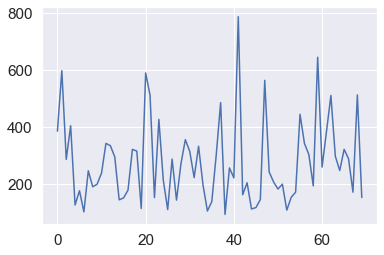

In [1116]:
plt.plot(pipe_LGBM_centro['model'].feature_importances_)

In [311]:
# Заменят значения ниже порогового на 0
class LowCutoffImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features, low_threshold=0.01):
        self.features = features
        self.low_threshold = low_threshold
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[X_transformed.loc[:, TIME_SERIES]<=self.low_threshold] = 0
        
        return X_transformed

# Добавляем кастомные классы обработки
class NanMaskEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()

        X_transformed.mask(((X_transformed==0) | (X_transformed>=1)), inplace=True)

        # NOTE: Не срабатывал при указании столбцов [self.features]
        X_transformed.mask(
            ((X_transformed[self.features]<=0) | (X_transformed[self.features] >=1)),
            inplace=True
        )
        
        return X_transformed

class MeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        # Заполняем пропущенные средними значениями по столбцам
        X_transformed = X_transformed.apply(lambda row: row.fillna(row.mean()), axis=0)

        return X_transformed

class LinRegImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()

        # Линейная интерполяция
        # NOTE: провереить, что axis=1 интерполирует вдоль рядов, а не столбцов!
        X_transformed.interpolate(method='linear', axis=1, inplace=True)
        #X_transformed.interpolate(method='polynomial', order=5, axis=1, inplace=True)

        # с заполнением оставшихся пропусков соседними значениями
        # Делается в NeighborImputer

        return X_transformed

class NeighborImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()

        X_transformed.fillna(
            method='bfill', axis=1, inplace=True
        )

        X_transformed.fillna(
            method='ffill', axis=1, inplace=True
        )
        return X_transformed

class RandomColumnAdder(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['rnd_col']=np.random.random_sample(X_transformed.shape[0])

        return X_transformed

class NumZerosColumnAdder(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        
        zeros = X_transformed.shape[1] - np.count_nonzero(X_transformed, axis=1)

        np.hstack((X_transformed, zeros.reshape(-1, 1)))

        return X_transformed

class ExtraColumnAdder(BaseEstimator, TransformerMixin):
    def __init__(self, features, col):
        self.features = features
        self.col = col
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        X_transformed = pd.concat([X_transformed, self.col], axis=1)
        print(X_transformed.shape)
        print(X_transformed)
        return X_transformed

class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        self.min = X[self.features].min()
        self.range = X[self.features].max()-self.min
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.features] = (X[self.features]-self.min)/self.range
        return X_transformed

from sklearn.preprocessing import StandardScaler
class CustomStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X)
        self.mean = self.scaler.mean_
        # @see docs by default std = 1
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed = self.scaler.fit_transform(X_transformed)
        return X_transformed

import numpy as np
class CustomFFT():
    def __init__(self, df_path):
        self.df_path = df_path
        self.df_ts = pd.read_csv(self.df_path)
        TS_COLS = self.df_ts.columns[
            self.df_ts.columns.str.contains('nd_mean_')].sort_values()
        self.X_TS = self.df_ts[TS_COLS].copy()
        self.N = self.X_TS.shape[-1]

    def amp_z(z):
        return 2.0 / self.N * np.abs(z)
    
    def phase_z(z):
        return np.angle(z)
    
    def fit(self, X, y=None):
        # TODO: здесь видимо интерполяция для эквидистантности точек семпла
        return self
    
    def transform(self, X):
        df_ts = pd.read_csv(self.df_path)
        TS_COLS = df_ts.columns[df_ts.columns.str.contains('nd_mean_')].sort_values()
        X_TS = df_ts[TS_COLS].copy()

        # Число точек семпла
        N = X_TS.shape[-1]
        # FFT берётся по строкам временных данных полей
        y_fft_z = np.fft.fft(X_TS)

        # Берём от комплексного числа модуль амплитуды
        amp_z = lambda z: 2.0 / N * np.abs(z)
        phase_z = lambda z: np.angle(z)
        y_fft_amp = amp_z(y_fft_z)
        y_fft_phase = phase_z(y_fft_z)
        #print(pd.DataFrame(y_fft_amp))
        #print(y_fft_phase[:,-1])
        #y_fft = 2.0 / N * np.abs(y_fft[:N//2])
        # NOTE: только с амплитудой теряется информация по фазе, возможно с ней будет точнее
        # Фазу можно записывать в строку после амплитуд

        # Нулевую компоненту с f=0 уполовиниваем (она одна, нет зеркальной)
        y_fft_amp[:, 0] = y_fft_amp[:, 0] / 2

        # Избавляемся от комплексного типа чисел исходного y_fft_z
        y_fft = np.zeros(y_fft_z.shape)
        # Берём половину амплитуд из симметричного набора
        y_fft[:, :N//2] = y_fft_amp[:, :N//2].astype(float)
        # В остальную половину значений пишем фазу
        y_fft[:, N//2:] = y_fft_phase[:, N//2:].astype(float)

        # Разница между точками данных 1 день, частоты будут обратные дню: 1/день
        freq_fft = np.fft.fftfreq(N, 1)

        # Тоже берём половину частот, избавляясль для амплитуды от зеркальной половины
        freq_fft = freq_fft[:N // 2]

        return (freq_fft, y_fft)
    
    def modulus_transform(self, X):
        return np.abs(np.fft.fft(X))

    def complex_transform(self):
        fourier = np.fft.fft(self.X_TS)
        #print(fourier.real.shape)
        #print(fourier.imag.shape)
        #return np.column_stack((fourier.real, fourier.imag))
        #return list(zip(fourier.real, fourier.imag))
        # NOTE: повторение из-за симметрии
        return np.hstack((fourier.real, fourier.imag))

from lightgbm import LGBMClassifier
class CustomLightGBMClassifier(LGBMClassifier):

    def fit(self, X, y=None, **fit_params):
        #print(X.filter(regex=f"{categorical_suffix}$").columns.to_list())

        return super().fit(
            X,
            y=y,
            #cat_features=X.filter(regex=f"{categorical_suffix}$").columns,
            **fit_params
        )

from xgboost import XGBClassifier
class CustomXGBoostClassifier(XGBClassifier):

    def fit(self, X, y=None, **fit_params):
        #print(X.filter(regex=f"{categorical_suffix}$").columns.to_list())

        return super().fit(
            X,
            y=y,
            #cat_features=X.filter(regex=f"{categorical_suffix}$").columns,
            **fit_params
        )

from catboost import CatBoostClassifier, Pool
class CustomCatBoostClassifier(CatBoostClassifier):

    def fit(self, X, y=None, **fit_params):
        #print(X.filter(regex=f"{categorical_suffix}$").columns.to_list())

        return super().fit(
            X,
            y=y,
            #cat_features=X.filter(regex=f"{categorical_suffix}$").columns,
            **fit_params
        )

In [349]:
df_path=f'{PROC_DIR}train_lin_interp.csv'
fft_obj = CustomFFT(df_path)
fft_freq, fft_amp = fft_obj.transform(_)

df_fft = pd.DataFrame(fft_amp)
FFT_COLS = df_fft.columns


# Только для амплитуд FFT было 0.74
# со StandardScaler -0.01
# Чистый CatBoost 0.775
# Для половины частот 0.66

# Чистый LGBM для амплитуд и фаз 0.874
# LGBM + Scaler 0.878
# XGBoost + Standard Scaler 0.875
# Чистый XGBoost 0.872
# Чистый CatBoost 0.877
# CatBoost + Standard Scaler: 0.872

# Обработка по парам значений БПФ

In [13]:
df_path=f'{PROC_DIR}train_lin_interp.csv'
fft_obj = CustomFFT(df_path)
#fft_freq, fft_amp = fft_obj.transform(_)
fft_pair = fft_obj.complex_transform()
print(fft_pair.shape)
#df_fft = pd.DataFrame(fft_amp)
#FFT_COLS = df_fft.columns

(4830, 270)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(fft_pair, df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)

In [110]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, accuracy_score


def classify(features, target, return_acc=False):
    X_train, X_test, y_train, y_test = train_test_split(
                                            features, target)
    clf = XGBClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    if return_acc:
        return acc
    print(f"Accuracy:\n {100* acc:.2f}%")
    print(f"Precision:\n {100* prec:.2f}%")

In [1120]:
X_train, X_test, y_train, y_test = train_test_split(df_train[TIME_SERIES], df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)
                                                    #stratify=df_train[TARGET])

In [359]:
ALL_COLS = ['area'] + list(FFT_COLS) + list(TIME_SERIES)

In [360]:
df_all_cols = pd.concat([df_train['area'], df_train[TIME_SERIES], df_fft[FFT_COLS]], axis=1)

In [361]:
X_train, X_test, y_train, y_test = train_test_split(df_all_cols,
                                                    df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)
                                                    #stratify=df_train[TARGET])

In [568]:
TS_AREA = list(TIME_SERIES) + ['area']

In [499]:
# У фаз разброс повеселее, смотрим только для фаз
X_train, X_test, y_train, y_test = train_test_split(df_fft[FFT_COLS[67:]], df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)
                                                    #stratify=df_train[TARGET])

In [196]:
# Only LGBM important features from last run
X_train, X_test, y_train, y_test = train_test_split(df_all_cols.loc[:, FI_COLS],
                                                    df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)
                                                    #stratify=df_train[TARGET])

In [388]:
TIME_SERIES.shape

(70,)

In [232]:
df_all_cols.iloc[:, 70]

0       0.2784
1       0.2986
2       0.2600
3       0.2729
4       0.2749
         ...  
4825    0.3007
4826    0.3592
4827    0.3333
4828    0.3035
4829    0.3217
Name: 0, Length: 4830, dtype: float64

In [230]:
df_all_cols.iloc[:, 70+67:]

,67,68,69,70,71,72,73,74,75,76,...,125,126,127,128,129,130,131,132,133,134
0,-2.5044,2.5044,-0.2435,1.3901,1.9296,-2.8621,-1.7317,-0.5806,-1.4964,-2.0367,...,0.5636,-0.7027,0.6084,-2.9806,-0.5441,1.1041,-0.3485,1.8115,2.9336,-2.0709
1,-3.0183,3.0183,-0.6055,0.9419,-0.0960,2.4337,2.9003,-0.5692,-2.1925,2.8029,...,0.5239,1.1523,2.3010,-2.2288,0.2514,-3.0180,0.5761,-2.7603,-1.0403,-2.6436
2,-1.3357,1.3357,-2.0654,0.9282,1.9194,-1.7477,1.1077,-0.4971,-2.0943,-1.1168,...,1.6809,2.5420,-0.8100,-2.8272,-0.3420,2.5823,-0.3298,2.7584,1.9209,-2.7120
3,1.1362,-1.1362,2.8182,0.4914,-2.2911,2.2617,-2.0414,2.8788,0.9360,-2.2531,...,-0.0552,-2.1366,-0.1128,2.8491,0.1822,-3.0913,0.6504,-1.0267,-2.6676,2.7844
4,-2.7189,2.7189,-1.0207,-1.4305,0.9932,-1.0470,-2.7287,-1.2613,2.2518,-0.5958,...,1.4025,-3.0848,0.5323,3.0576,-1.0155,2.3435,0.1904,1.8743,2.7764,-2.0937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,-1.5766,1.5766,0.9061,1.2124,2.3973,3.1116,-2.3367,-1.1844,-0.2813,-0.3195,...,1.5595,-2.5268,-0.6992,-2.9679,-0.4429,2.3857,0.7549,1.7411,2.7383,-1.9692
4826,-1.9516,1.9516,1.1321,0.7416,2.9164,0.9245,-0.6536,-0.9738,-1.9238,-1.1656,...,1.9072,-2.2732,-0.1077,3.0859,-0.2871,2.5308,0.1970,2.3244,2.9171,-2.1937
4827,-2.0842,2.0842,-2.2814,2.7162,2.6048,0.5566,2.6068,-1.2927,-2.8928,-0.6433,...,1.9226,-2.6771,-1.7574,-2.7603,-0.5247,-2.7713,0.6031,-2.4977,-2.8722,-1.9522
4828,0.4208,-0.4208,-2.8402,0.1124,3.0345,0.6830,-1.8279,2.9906,0.8779,-2.9973,...,1.4137,-1.5649,-0.0157,-2.9680,-0.5391,1.1568,-0.9133,-1.1239,0.3393,3.0551


In [ ]:
# Попробуем вычесть средние амплитуды и фазы
df_all_cols.iloc[:, (70 + 67):] = df_all_cols.iloc[:, (70 + 67):] - df_fft_phase_avg_single.iloc[67:]

In [235]:
df_all_cols.iloc[:, 70:(70 + 67)] = 1000*df_all_cols.iloc[:, 70:(70 + 67)] - 1000*df_fft_phase_avg_single.iloc[:67]

In [236]:
df_all_cols

,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,...,125,126,127,128,129,130,131,132,133,134
0,0.1872,0.0728,0.2623,0.2618,0.0631,0.0630,0.0000,0.0776,0.1044,0.0005,...,-0.2563,0.6526,0.6286,-3.6828,-0.2994,-0.0977,-0.1887,1.9206,1.9082,-0.2646
1,0.2453,0.3329,0.3491,0.2872,0.0647,0.0971,0.0245,0.1736,0.1525,0.1964,...,-0.2960,2.5076,2.3212,-2.9311,0.4961,-4.2198,0.7359,-2.6512,-2.0657,-0.8373
2,0.0064,0.0137,0.0000,0.0071,0.0000,0.1208,0.1125,0.0418,0.0378,0.1690,...,0.8610,3.8973,-0.7897,-3.5294,-0.0973,1.3805,-0.1701,2.8675,0.8955,-0.9057
3,0.2934,0.1060,0.3180,0.0525,0.1537,0.0019,0.0451,0.0726,0.0115,0.0000,...,-0.8751,-0.7813,-0.0926,2.1468,0.4269,-4.2931,0.8102,-0.9176,-3.6930,4.5908
4,0.0280,0.1309,0.1172,0.0635,0.0406,0.0244,0.1639,0.1094,0.0000,0.0218,...,0.5826,-1.7294,0.5526,2.3553,-0.7708,1.1418,0.3502,1.9834,1.7510,-0.2874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,0.0662,0.0288,0.0000,0.0383,0.0000,0.2553,0.0958,0.2416,0.1482,0.2417,...,0.7395,-1.1714,-0.6789,-3.6702,-0.1982,1.1839,0.9147,1.8502,1.7129,-0.1629
4826,0.2439,0.0359,0.0134,0.0307,0.2465,0.0339,0.0000,0.0222,0.0296,0.0571,...,1.0873,-0.9178,-0.0874,2.3836,-0.0423,1.3290,0.3567,2.4335,1.8917,-0.3874
4827,0.0900,0.1913,0.0199,0.0636,0.0000,0.1401,0.1439,0.2187,0.3240,0.0033,...,1.1027,-1.3218,-1.7371,-3.4625,-0.2800,-3.9731,0.7628,-2.3886,-3.8976,-0.1459
4828,0.3017,0.2914,0.2951,0.2214,0.3265,0.0072,0.0069,0.0000,0.0551,0.1453,...,0.5938,-0.2096,0.0046,-3.6703,-0.2944,-0.0449,-0.7536,-1.0148,-0.6861,4.8614


In [238]:
# С вычетом среднего по амплитуде и фазе
X_train, X_test, y_train, y_test = train_test_split(df_all_cols,
                                                    df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)
                                                    #stratify=df_train[TARGET])

In [250]:
df_ts_avg_by_crop = pd.concat([df_all_cols.iloc[:, :70], df_train.crop], axis=1).groupby('crop').mean()
df_ts_avg_by_crop

,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,...,nd_mean_2021-07-29,nd_mean_2021-07-31,nd_mean_2021-08-01,nd_mean_2021-08-07,nd_mean_2021-08-10,nd_mean_2021-08-11,nd_mean_2021-08-12,nd_mean_2021-08-13,nd_mean_2021-08-23,nd_mean_2021-08-27
crop,,,,,,,,,,,,,,,,,,,,,
0,0.1742,0.2140,0.1776,0.0799,0.0802,0.1620,0.0819,0.0742,0.2040,0.0784,...,0.5059,0.3967,0.4843,0.4570,0.0800,0.0779,0.4430,0.0826,0.0835,0.0817
1,0.0809,0.0796,0.0768,0.0855,0.0806,0.2267,0.0793,0.0790,0.0884,0.1421,...,0.4588,0.4348,0.4828,0.0770,0.3152,0.3022,0.4781,0.0729,0.3880,0.0799
2,0.0822,0.1934,0.0761,0.1336,0.0786,0.1892,0.0794,0.0774,0.2349,0.0853,...,0.3379,0.3856,0.0821,0.3167,0.0784,0.0825,0.3392,0.0819,0.0816,0.0834
3,0.1883,0.0823,0.2050,0.1533,0.1925,0.0830,0.1449,0.1304,0.0809,0.0771,...,0.4587,0.0793,0.4526,0.0792,0.0825,0.2981,0.4389,0.3836,0.0782,0.2828
4,0.1484,0.1808,0.1560,0.1474,0.0821,0.2127,0.0771,0.1491,0.1765,0.1256,...,0.4871,0.4213,0.4848,0.3289,0.0792,0.2720,0.5087,0.0796,0.0797,0.0792
5,0.2412,0.2098,0.2405,0.0746,0.2381,0.0826,0.0810,0.0718,0.1818,0.0799,...,0.0836,0.0808,0.0798,0.0757,0.2363,0.3289,0.4378,0.0858,0.2479,0.3435
6,0.0777,0.0816,0.0838,0.1606,0.0803,0.1460,0.0798,0.1351,0.1915,0.0814,...,0.4822,0.4358,0.5014,0.4788,0.0800,0.0802,0.5367,0.0795,0.2212,0.0848


In [251]:
df_ts_avg_by_crop_single = df_ts_avg_by_crop.mean()
df_ts_avg_by_crop_single

nd_mean_2021-04-15    0.1419
nd_mean_2021-04-16    0.1488
nd_mean_2021-04-18    0.1451
nd_mean_2021-04-19    0.1193
nd_mean_2021-04-20    0.1189
                       ...  
nd_mean_2021-08-11    0.2060
nd_mean_2021-08-12    0.4546
nd_mean_2021-08-13    0.1237
nd_mean_2021-08-23    0.1686
nd_mean_2021-08-27    0.1479
Length: 70, dtype: float64

<AxesSubplot:>

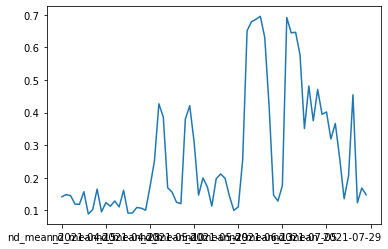

In [252]:
df_ts_avg_by_crop_single.plot()

In [253]:
df_all_cols.iloc[:, 70] = df_all_cols.iloc[:, 70] - df_ts_avg_by_crop_single

In [254]:
# С вычетом среднего по амплитуде и фазе, а также time series
X_train, X_test, y_train, y_test = train_test_split(df_all_cols,
                                                    df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)
                                                    #stratify=df_train[TARGET])

In [1228]:
# Только Time Series за вычетом среднего значения
X_train, X_test, y_train, y_test = train_test_split(df_train[TIME_SERIES] - df_ts_avg_by_crop_single,
                                                    df_train[TARGET],
                                                    test_size=0.2, random_state=SEED)
                                                    #stratify=df_train[TARGET])

NameError: name 'df_ts_avg_by_crop_single' is not defined

In [367]:
df_features_col_names = ['fft_amp_feat_' + str(feat_col) for feat_col in df_features.columns]
df_features_col_names

['fft_amp_feat_0',
 'fft_amp_feat_1',
 'fft_amp_feat_2',
 'fft_amp_feat_3',
 'fft_amp_feat_4',
 'fft_amp_feat_5',
 'fft_amp_feat_6',
 'fft_amp_feat_7',
 'fft_amp_feat_8',
 'fft_amp_feat_9',
 'fft_amp_feat_10',
 'fft_amp_feat_11',
 'fft_amp_feat_12',
 'fft_amp_feat_13',
 'fft_amp_feat_14',
 'fft_amp_feat_15',
 'fft_amp_feat_16',
 'fft_amp_feat_17',
 'fft_amp_feat_18',
 'fft_amp_feat_19',
 'fft_amp_feat_20']

In [370]:
dict(zip(df_features.columns, df_features_col_names))

{0: 'fft_amp_feat_0',
 1: 'fft_amp_feat_1',
 2: 'fft_amp_feat_2',
 3: 'fft_amp_feat_3',
 4: 'fft_amp_feat_4',
 5: 'fft_amp_feat_5',
 6: 'fft_amp_feat_6',
 7: 'fft_amp_feat_7',
 8: 'fft_amp_feat_8',
 9: 'fft_amp_feat_9',
 10: 'fft_amp_feat_10',
 11: 'fft_amp_feat_11',
 12: 'fft_amp_feat_12',
 13: 'fft_amp_feat_13',
 14: 'fft_amp_feat_14',
 15: 'fft_amp_feat_15',
 16: 'fft_amp_feat_16',
 17: 'fft_amp_feat_17',
 18: 'fft_amp_feat_18',
 19: 'fft_amp_feat_19',
 20: 'fft_amp_feat_20'}

In [379]:
df_features.rename(columns=dict(zip(df_features.columns, df_features_col_names)), inplace=True)
df_features

,fft_amp_feat_0,fft_amp_feat_1,fft_amp_feat_2,fft_amp_feat_3,fft_amp_feat_4,fft_amp_feat_5,fft_amp_feat_6,fft_amp_feat_7,fft_amp_feat_8,fft_amp_feat_9,...,fft_amp_feat_11,fft_amp_feat_12,fft_amp_feat_13,fft_amp_feat_14,fft_amp_feat_15,fft_amp_feat_16,fft_amp_feat_17,fft_amp_feat_18,fft_amp_feat_19,fft_amp_feat_20
0,-2.6000,-0.5711,0.9644,-3.4392,-0.8762,0.7613,2.7774,0.4249,0.1342,0.6081,...,-2.5737,0.6196,-3.3393,-2.6556,-0.3975,1.6217,-1.3257,0.9826,3.8856,-1.6375
1,-0.5766,-2.8375,-4.5613,-4.3242,-1.3981,-3.0965,0.5229,-5.4404,-5.1179,-2.9489,...,4.5788,-0.9499,4.5647,3.0002,1.1089,0.3027,-2.5333,-0.0973,1.5675,0.8960
2,-4.4398,1.7024,-4.3844,-0.7029,-3.3781,1.4903,3.3469,-2.7084,-5.8866,-3.3505,...,-0.3579,-1.3328,0.5241,0.8670,-0.2931,-0.1246,-0.4453,-0.6324,-1.8633,-1.2496
3,-3.1516,-1.5827,-1.3593,4.3793,2.8674,-0.8386,0.1102,-3.4585,4.4985,-2.4087,...,-1.8895,-2.6905,-1.9938,-1.1464,0.1936,1.8682,-2.6095,1.1211,-0.9902,-0.6156
4,-2.9494,7.2671,6.5086,1.1603,0.9599,-2.9914,0.9264,-0.5394,0.7902,-1.2925,...,-2.0123,-2.1641,-1.1573,-2.8679,-0.1178,0.1218,-1.5591,0.4832,-1.8092,-0.8942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,-0.3712,6.7959,7.4275,0.0297,-3.4417,0.8522,1.6165,-0.9379,-0.7491,-0.8712,...,-1.2928,-0.3832,-2.0888,0.4985,0.7655,-0.2242,0.3403,-2.0491,-1.1061,0.6403
4826,5.4796,12.2345,5.2274,3.5710,-0.9168,0.1732,6.0126,-0.9626,0.3522,-1.9197,...,-1.2454,-2.7849,-0.5041,-1.2500,-1.8265,-1.2467,-0.7765,-2.1600,0.9425,1.0046
4827,2.8860,4.2247,-4.1194,-4.0756,-0.4089,-3.5059,11.6555,6.8718,-4.1982,3.3759,...,0.3204,-2.1794,-0.6348,-2.2099,-1.1277,0.7412,0.2401,-2.3368,-0.4457,-0.5024
4828,-0.0934,-3.5502,-3.4654,0.8622,2.0158,0.0174,-2.5173,-2.4556,2.5468,-2.1124,...,-3.5030,2.2024,0.4462,4.0566,-0.8387,0.4924,-0.0898,1.8431,1.6762,-0.0523


In [411]:
# Попытка построения фичей из FFT
#(100*df_fft_phase_avg.iloc[crop, :21]-100*df_fft_phase_avg_single.iloc[:21])

df_features = (100*df_fft.iloc[:, :21] - 100*df_fft_phase_avg_single.iloc[:21])

df_features.rename(columns=dict(zip(df_features.columns, df_features_col_names)), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(pd.concat([df_features, df_all_cols], axis=1),
                                                    df_train[TARGET],
                                                    test_size=0.2, random_state=SEED+10)

In [402]:
X_train, X_test, y_train, y_test = train_test_split(df_train[list(TS_FI_COLS) + ['area']],
                                                    df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED+10)

In [1232]:
X_train, X_test, y_train, y_test = train_test_split(df_train[TIME_SERIES],
                                                    df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)

In [1229]:
X_train, X_test, y_train, y_test = train_test_split(df_train[TS_AREA],
                                                    df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)

In [922]:
lgb_grid_cv_params = {
    'boosting_type': 'dart', 'colsample_bytree': 0.64, 'learning_rate': 0.01,
    'max_bin': 255, 'n_estimators': 24, 'num_leaves': 16, 'objective': 'multiclass',
    'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7
}

In [923]:
mdl = LGBMClassifier(metric='multi_logloss', **lgb_grid_cv_params)
mdl.fit(X_train, y_train)

y_pred = mdl.predict(X_test)
print('\n',recall_score(y_test, y_pred, average="macro", zero_division=0))
#print(mdl)


 0.938927217440593


# LGBM Grid Search 2

In [1117]:
# @link https://www.kaggle.com/code/bitit1994/parameter-grid-search-lgbm-with-scikit-learn/notebook
import numpy as np
import pandas as pd
from time import gmtime, strftime
import gc

from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import (roc_curve, auc, accuracy_score)

In [1119]:
params = {
    'objective': 'multiclass',
    #'application': 'binary', # for binary classification
    'num_class' : 7, # used for multi-classes
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'device': 'cpu', # you can use GPU to achieve faster learning
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'multi_logloss',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

# Initiate classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'multiclass', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'])

# To view the default model parameters:
mdl.get_params().keys()
#dict_keys(['boosting_type', 'colsample_bytree', 'learning_rate', 'max_bin', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin'])

In [ ]:
gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['multiclass'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X, y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

In [1243]:
from sklearn.impute import SimpleImputer

gbm_params['metric'] = 'multi_logloss'

pipe = Pipeline([
    #('nan_masker', NanMaskEncoder(ALL_COLS)),
    #('mean_imputer', MeanImputer(ALL_COLS)),
    #('linreg_imputer', LinRegImputer(NUMERICAL)),
    #('num_imputer', NeighborImputer(NUMERICAL)),
    #('rnd_coll_adder', RandomColumnAdder(ALL_COLS)),
    #('rnd_coll_adder_2', RandomColumnAdder(TIME_SERIES)),
    #('rnd_coll_adder_3', RandomColumnAdder(TIME_SERIES)),
    #('rnd_coll_adder_4', RandomColumnAdder(TIME_SERIES)),
    #('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    #('num_imputer', NeighborImputer(NUMERICAL)),
    #('std_scaler', CustomStandardScaler(ALL_COLS)),

    ('zeroing', LowCutoffImputer(TS_AREA, 0.01)),
    #('nan_masker', NanMaskEncoder(TIME_SERIES)),
    #('rnd_coll_adder_2', RandomColumnAdder(TS_AREA)),
    #('rnd_coll_adder_3', RandomColumnAdder(TIME_SERIES)),
    #('rnd_coll_adder_4', RandomColumnAdder(TIME_SERIES)),
    #('zeroing', LowCutoffImputer(TS_FI_COLS, 0.01)),
    #('nan_masker', NanMaskEncoder(TS_FI_COLS)),
    #('rnd_coll_adder_2', RandomColumnAdder(TIME_SERIES)),
    #('rnd_coll_adder_3', RandomColumnAdder(TIME_SERIES)),
    #('rnd_coll_adder_4', RandomColumnAdder(TIME_SERIES)),

    #('linreg_imputer', LinRegImputer(TIME_SERIES)),
    #('mean_imputer', MeanImputer(TIME_SERIES)),
    
    #('minmax_scaler', MinMaxScaler()),
    #('zero_col_adder', NumZerosColumnAdder(TIME_SERIES)),

    #('scaler', Scaler(TIME_SERIES)),
    #('std_scaler', CustomStandardScaler(TIME_SERIES)),
    #('std_scaler', CustomStandardScaler(TS_AREA)),
    #('cat_imputer', Imputer(CATEGORICAL)),
    #('encoder', Encoder(CATEGORICAL)),
    #('model', RandomForestClassifier(random_state=SEED, n_estimators = 3))

    #('area_col_adder', ExtraColumnAdder(TIME_SERIES, X_train['area'])),
    
    #('model', CustomLightGBMClassifier(**lgb_grid_cv_params)),
    #('model', CustomLightGBMClassifier(random_state=42,
    #    objective='multiclass',
    #    metric='multi_logloss',
    #    boosting_type='gbdt',
    #    n_estimators=58,
    #   max_bin=255)),
    #('model', CustomLightGBMClassifier(**lgb_params)),
    #('std_scaler', StandardScaler()),
    #('pca', PCA()),
    ('std_scaler2', CustomStandardScaler(TS_AREA)),
    ('model', CustomLightGBMClassifier(**gbm_params)),
    #('model', CustomLightGBMClassifier(random_state=SEED, objective='multiclass', metric='multi_logloss',
    #                                  boosting_type='gbdt')),
    #('model', CustomXGBoostClassifier(
    #    random_state=SEED, eval_metric='auc', #'mlogloss'
    #    objective='multi:softprob',
    #    max_depth=2, n_estimators=10,
    #    use_label_encoder=False)
    #), # scoring='roc_auc'
    #('model', CustomCatBoostClassifier(random_state=SEED, logging_level="Silent"))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('zeroing',
                 LowCutoffImputer(features=['nd_mean_2021-04-15',
                                            'nd_mean_2021-04-16',
                                            'nd_mean_2021-04-18',
                                            'nd_mean_2021-04-19',
                                            'nd_mean_2021-04-20',
                                            'nd_mean_2021-04-22',
                                            'nd_mean_2021-04-23',
                                            'nd_mean_2021-04-25',
                                            'nd_mean_2021-04-26',
                                            'nd_mean_2021-04-27',
                                            'nd_mean_2021-04-28',
                                            'nd_mean_2021-04-29',
                                            'nd_mean_2021-04-30',
                                            'nd_mean_2021-05-01',
                                            'n...
                                                'nd_mean_2021-05-19',
                                                'nd_mean_2021-05-20',
                                                'nd_mean_2021-05-21',
                                                'nd_mean_2021-05-24',
                                                'nd_mean_2021-05-26',
                                                'nd_mean_2021-05-27', ...])),
                ('model',
                 CustomLightGBMClassifier(colsample_bytree=0.65,
                                          learning_rate=0.01, max_bin=1024,
                                          metric='multi_logloss',
                                          n_estimators=256, num_leaves=16,
                                          objective='multiclass',
                                          random_state=42, reg_alpha=1,
                                          reg_lambda=1.2, subsample=0.7))])

In [1244]:
from sklearn.metrics import recall_score, precision_score

y_pred = pipe.predict(X_test)
print('\n',recall_score(y_test, y_pred, average="macro", zero_division=0))
#print(pipe)
#print(type(pred), pred.shape, pred)


 0.9613847182155405


In [1265]:
scores = cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(n_splits=5))
scores

array([0.95860285, 0.96377749, 0.96248383, 0.95730918, 0.96373057])

In [1267]:
np.mean(scores)

0.9611807841060667

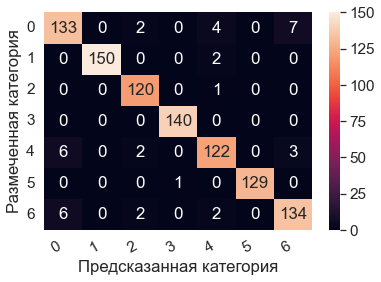

In [1268]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=range(7), columns=range(7))

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('Размеченная категория')
plt.xlabel('Предсказанная категория');

In [ ]:
# n_estimators рекорды
# 45, 46, 47, 49, 52
# 54, 55, 56 0.9738473586893951
# 57, 58 0.9748463596883961
# 59, 60
# 61 уже не рекорд 0.9709178557598922

In [913]:
# 0.9748463596883961
lgb_record_params = {
    'random_state': SEED,
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'n_estimators': 58,
    'num_leaves': 16,
    'max_bin': 255,
    
    #'boosting_type': 'dart', 'colsample_bytree': 0.64, 'learning_rate': 0.01,
    #'max_bin': 255, 'n_estimators': 24, 'num_leaves': 16, 'objective': 'multiclass',
    #'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7
}
lgb_params = lgb_record_params
print(lgb_record_params)

{'random_state': 42, 'objective': 'multiclass', 'metric': 'multi_logloss', 'boosting_type': 'gbdt', 'n_estimators': 58, 'num_leaves': 16, 'max_bin': 255}


In [894]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('zeroing',
                 LowCutoffImputer(features=['nd_mean_2021-04-15',
                                            'nd_mean_2021-04-16',
                                            'nd_mean_2021-04-18',
                                            'nd_mean_2021-04-19',
                                            'nd_mean_2021-04-20',
                                            'nd_mean_2021-04-22',
                                            'nd_mean_2021-04-23',
                                            'nd_mean_2021-04-25',
                                            'nd_mean_2021-04-26',
                                            'nd_mean_2021-04-27',
                                            'nd_mean_2021-04-28',
                                            'nd_mean_2021-04-29',
                                            'nd_mean_2021-04-30',
                                            'nd_mean_2021-05-01',
                                            'n...
                                            'nd_mean_2021-05-10',
                                            'nd_mean_2021-05-15',
                                            'nd_mean_2021-05-16',
                                            'nd_mean_2021-05-17',
                                            'nd_mean_2021-05-19',
                                            'nd_mean_2021-05-20',
                                            'nd_mean_2021-05-21',
                                            'nd_mean_2021-05-24',
                                            'nd_mean_2021-05-26',
                                            'nd_mean_2021-05-27', ...])),
                ('model',
                 CustomLightGBMClassifier(boosting_type='dart', max_bin=255,
                                          metric='multi_logloss',
                                          n_estimators=58,
                                          objective='multiclass',
                                          random_state=42))])

In [895]:
from sklearn.metrics import recall_score, precision_score

y_pred = pipe.predict(X_test)
print('\n',recall_score(y_test, y_pred, average="macro", zero_division=0))


 0.9548391213661956


In [968]:
df_train.shape

(4830, 74)

In [969]:
df_test.shape

(2071, 73)

In [851]:
pipe.fit(df_train[TS_AREA], df_train[TARGET])

Pipeline(steps=[('zeroing',
                 LowCutoffImputer(features=['nd_mean_2021-04-15',
                                            'nd_mean_2021-04-16',
                                            'nd_mean_2021-04-18',
                                            'nd_mean_2021-04-19',
                                            'nd_mean_2021-04-20',
                                            'nd_mean_2021-04-22',
                                            'nd_mean_2021-04-23',
                                            'nd_mean_2021-04-25',
                                            'nd_mean_2021-04-26',
                                            'nd_mean_2021-04-27',
                                            'nd_mean_2021-04-28',
                                            'nd_mean_2021-04-29',
                                            'nd_mean_2021-04-30',
                                            'nd_mean_2021-05-01',
                                            'n...
                                            'nd_mean_2021-05-09',
                                            'nd_mean_2021-05-10',
                                            'nd_mean_2021-05-15',
                                            'nd_mean_2021-05-16',
                                            'nd_mean_2021-05-17',
                                            'nd_mean_2021-05-19',
                                            'nd_mean_2021-05-20',
                                            'nd_mean_2021-05-21',
                                            'nd_mean_2021-05-24',
                                            'nd_mean_2021-05-26',
                                            'nd_mean_2021-05-27', ...])),
                ('model',
                 CustomLightGBMClassifier(max_bin=255, metric='multi_logloss',
                                          n_estimators=58,
                                          objective='multiclass',
                                          random_state=42))])

In [950]:
y_sub = pipe.predict(df_test[TS_AREA])

In [951]:
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_sub.astype(int))}).to_csv(
    f'{OUT_DIR}lgbm_grid_search.1.csv', sep=',', index=None)

In [490]:
pipe_RFC = Pipeline([
    #('zeroing', LowCutoffImputer(TS_FI_COLS, 0.01)),
    ('model', RandomForestClassifier(random_state=SEED, n_estimators = 10))
])

In [491]:
pipe_RFC.fit(X_train, y_train)

Pipeline(steps=[('model',
                 RandomForestClassifier(n_estimators=10, random_state=42))])

In [445]:
pipe_LGBM = Pipeline([
    #('zeroing', LowCutoffImputer(TS_FI_COLS, 0.01)),
    ('model', CustomLightGBMClassifier(random_state=SEED)),
])

In [482]:
pipe_LGBM.fit(X_train, y_train)

Pipeline(steps=[('model', CustomLightGBMClassifier(random_state=42))])

In [446]:
pipe_XGBoost = Pipeline([
    #('zeroing', LowCutoffImputer(TS_FI_COLS, 0.01)),
    ('model', CustomXGBoostClassifier(
        random_state=SEED, eval_metric='auc', objective='multi:softprob',
        use_label_encoder=False)
    )
])

In [483]:
pipe_XGBoost.fit(X_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Pipeline(steps=[('model',
                 CustomXGBoostClassifier(base_score=0.5, booster='gbtree',
                                         colsample_bylevel=1,
                                         colsample_bynode=1, colsample_bytree=1,
                                         enable_categorical=False,
                                         eval_metric='auc', gamma=0, gpu_id=-1,
                                         importance_type=None,
                                         interaction_constraints='',
                                         learning_rate=0.300000012,
                                         max_delta_step=0, max_depth=6,
                                         min_child_weight=1, missing=nan,
                                         monotone_constraints='()',
                                         n_estimators=100, n_jobs=8,
                                         num_parallel_tree=1,
                                         objective='multi:softprob',
                                         predictor='auto', random_state=42,
                                         reg_alpha=0, reg_lambda=1,
                                         scale_pos_weight=None, subsample=1,
                                         tree_method='exact',
                                         use_label_encoder=False,
                                         validate_parameters=1, ...))])

In [433]:
from sklearn.metrics import recall_score, precision_score

pred = pipe.predict(X_test)
print('\n',recall_score(y_test, pred, average="macro", zero_division=0))
#print(pipe)
#print(type(pred), pred.shape, pred)


 0.9785943223443223


In [ ]:
df_train[list(TIME_SERIES) + ['area']]

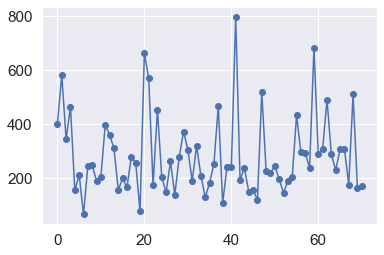

In [434]:
plt.plot(pipe['model'].feature_importances_, marker='o')

In [380]:
sum(pipe['model'].feature_importances_<180)

19

In [391]:
TS_FI_COLS_IDX = np.where(pipe['model'].feature_importances_>150)
TS_FI_COLS_IDX

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51], dtype=int64),)

In [392]:
TS_FI_COLS = TIME_SERIES[TS_FI_COLS_IDX[0][:-1]]
TS_FI_COLS

Index(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-28', 'nd_mean_2021-04-29',
       'nd_mean_2021-04-30', 'nd_mean_2021-05-01', 'nd_mean_2021-05-02',
       'nd_mean_2021-05-03', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07',
       'nd_mean_2021-05-08', 'nd_mean_2021-05-09', 'nd_mean_2021-05-10',
       'nd_mean_2021-05-15', 'nd_mean_2021-05-16', 'nd_mean_2021-05-17',
       'nd_mean_2021-05-19', 'nd_mean_2021-05-20', 'nd_mean_2021-05-21',
       'nd_mean_2021-05-24', 'nd_mean_2021-05-26', 'nd_mean_2021-05-27',
       'nd_mean_2021-05-29', 'nd_mean_2021-06-02', 'nd_mean_2021-06-03',
       'nd_mean_2021-06-04', 'nd_mean_2021-06-05', 'nd_mean_2021-06-06',
       'nd_mean_2021-06-07', 'nd_mean_2021-06-09', 'nd_mean_2021-06-10',
       'nd_mean_2021-06-12', 'nd_mean_2021-06-13', 

In [114]:
# 0.8776160067877453
# fft_pair, 135*2 = 270 (columns), hstack
# + MinMaxScaler() 0.8894748360423367

In [617]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)

In [618]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

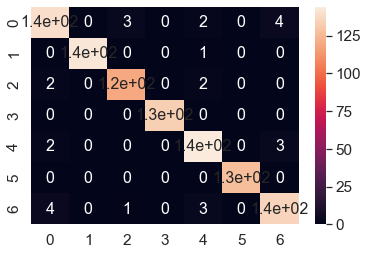

In [622]:
df_cm = pd.DataFrame(cm, range(7), range(7))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

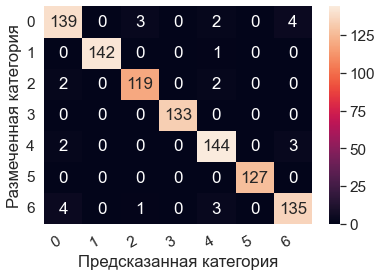

In [623]:
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=range(7), columns=range(7))

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('Размеченная категория')
plt.xlabel('Предсказанная категория');

In [633]:
rnd_col = pd.Series(np.random.random_sample(df_train.shape[0]), name='rnd_col')

pipe.fit(pd.concat([df_train[TS_AREA], rnd_col], axis=1),
                 df_train[TARGET])

Pipeline(steps=[('zeroing',
                 LowCutoffImputer(features=['nd_mean_2021-04-15',
                                            'nd_mean_2021-04-16',
                                            'nd_mean_2021-04-18',
                                            'nd_mean_2021-04-19',
                                            'nd_mean_2021-04-20',
                                            'nd_mean_2021-04-22',
                                            'nd_mean_2021-04-23',
                                            'nd_mean_2021-04-25',
                                            'nd_mean_2021-04-26',
                                            'nd_mean_2021-04-27',
                                            'nd_mean_2021-04-28',
                                            'nd_mean_2021-04-29',
                                            'nd_mean_2021-04-30',
                                            'nd_mean_2021-05-01',
                                            'n...
                                             'nd_mean_2021-05-04',
                                             'nd_mean_2021-05-07',
                                             'nd_mean_2021-05-08',
                                             'nd_mean_2021-05-09',
                                             'nd_mean_2021-05-10',
                                             'nd_mean_2021-05-15',
                                             'nd_mean_2021-05-16',
                                             'nd_mean_2021-05-17',
                                             'nd_mean_2021-05-19',
                                             'nd_mean_2021-05-20',
                                             'nd_mean_2021-05-21',
                                             'nd_mean_2021-05-24',
                                             'nd_mean_2021-05-26',
                                             'nd_mean_2021-05-27', ...])),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [637]:
rnd_col[:df_test.shape[0]]

0       0.0696
1       0.8857
2       0.5464
3       0.2579
4       0.8351
         ...  
2066    0.8588
2067    0.0877
2068    0.6558
2069    0.2094
2070    0.4747
Name: rnd_col, Length: 2071, dtype: float64

In [638]:
y_sub = pipe.predict(pd.concat([df_test[TS_AREA], rnd_col[:df_test.shape[0]]], axis=1))

In [639]:
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_sub.astype(int))}).to_csv(
    f'{OUT_DIR}low_cutoff_rnd_collgbm.csv', sep=',', index=None)

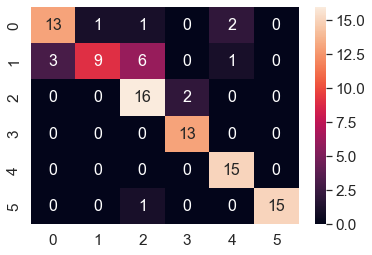

In [427]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[13,1,1,0,2,0],
         [3,9,6,0,1,0],
         [0,0,16,2,0,0],
         [0,0,0,13,0,0],
         [0,0,0,0,15,0],
         [0,0,1,0,0,15]]

df_cm = pd.DataFrame(array, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [332]:
pipe.fit(df_train[list(TIME_SERIES) + ['area']], df_train[TARGET])

Pipeline(steps=[('zeroing',
                 LowCutoffImputer(features=Index(['nd_mean_2021-04-16', 'nd_mean_2021-05-10', 'nd_mean_2021-05-15',
       'nd_mean_2021-06-16', 'nd_mean_2021-06-27', 'nd_mean_2021-07-27',
       'nd_mean_2021-08-01'],
      dtype='object'))),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [435]:
y_pred = pipe.predict(df_test[list(TIME_SERIES) + ['area']])

In [436]:
# LGBM на FFT AMP Features + TIME_SERIES
#Сохраняем в csv файл
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_pred.astype(int))}).to_csv(
    f'{OUT_DIR}min_threshold_adj.area.0.05.tts.lgbm.csv', sep=',', index=None)

# Stacking Classifier

In [438]:
# @link https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier
# Example
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
X, y = load_iris(return_X_y=True)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)
clf.fit(X_train, y_train).score(X_test, y_test)

0.9473684210526315

In [497]:
estimators = [
    ('rfc', pipe_RFC),
    ('lgbm', pipe_LGBM),
    ('xgboost', pipe_XGBoost)
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), cv=5,
    stack_method='auto'
)

X_train, X_test, y_train, y_test = train_test_split(df_train[TS_AREA],
                                                    df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=SEED
)
clf.fit(X_train, y_train).score(X_test, y_test)

0.9210526315789473

In [450]:
clf.fit(df_train[TS_AREA], df_train[TARGET])

D:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

StackingClassifier(estimators=[('lgbm',
                                Pipeline(steps=[('model',
                                                 CustomLightGBMClassifier(random_state=42))])),
                               ('xgboost',
                                Pipeline(steps=[('model',
                                                 CustomXGBoostClassifier(base_score=None,
                                                                         booster=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         enable_categorical=False,
                                                                         eval_metric='auc',
                                                                         gamma=None,
                                                                         gpu_id=None,
                                                                         importance_type=No...
                                                                         min_child_weight=None,
                                                                         missing=nan,
                                                                         monotone_constraints=None,
                                                                         n_estimators=100,
                                                                         n_jobs=None,
                                                                         num_parallel_tree=None,
                                                                         objective='multi:softprob',
                                                                         predictor=None,
                                                                         random_state=42,
                                                                         reg_alpha=None,
                                                                         reg_lambda=None,
                                                                         scale_pos_weight=None,
                                                                         subsample=None,
                                                                         tree_method=None,
                                                                         use_label_encoder=False,
                                                                         validate_parameters=None, ...))]))],
                   final_estimator=LogisticRegression())

In [451]:
y_pred = clf.predict(df_test[TS_AREA])

D:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [452]:
#Сохраняем в csv файл
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_pred.astype(int))}).to_csv(
    f'{OUT_DIR}stacking.lgbm.xgboost.logreg.csv', sep=',', index=None)


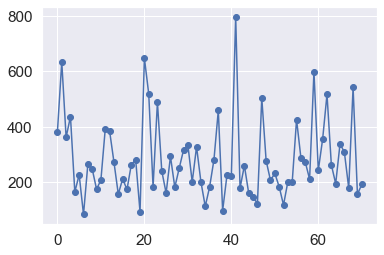

In [335]:
plt.plot(pipe['model'].feature_importances_, marker='o')

In [420]:
r, c=df_train.shape
r*c/(df_train==0).sum().sum()

8.503925767309065

In [326]:
pipe.fit(pd.concat([df_features, df_train[TIME_SERIES]], axis=1), df_train[TARGET])

Pipeline(steps=[('model', CustomLightGBMClassifier(random_state=42))])

In [399]:
df_test_features = (100*df_test_fft.iloc[:, :21] - 100*df_fft_phase_avg_single.iloc[:21])
df_test_features.rename(columns=dict(zip(df_test_features.columns, df_features_col_names)), inplace=True)
df_test_features

,fft_amp_feat_0,fft_amp_feat_1,fft_amp_feat_2,fft_amp_feat_3,fft_amp_feat_4,fft_amp_feat_5,fft_amp_feat_6,fft_amp_feat_7,fft_amp_feat_8,fft_amp_feat_9,...,fft_amp_feat_11,fft_amp_feat_12,fft_amp_feat_13,fft_amp_feat_14,fft_amp_feat_15,fft_amp_feat_16,fft_amp_feat_17,fft_amp_feat_18,fft_amp_feat_19,fft_amp_feat_20
0,2.6995,-3.1957,-2.8320,5.7732,1.2018,-0.3875,0.2799,9.9135,-0.2281,-2.0689,...,2.3595,1.7714,-0.7425,-0.4275,-1.8270,0.3220,-2.4664,1.0812,0.7457,-1.5405
1,0.5652,2.0305,-0.2382,-5.3548,-0.0861,2.0088,4.1730,-1.1524,2.1413,1.5302,...,1.0610,-0.7908,-0.8310,-1.7108,-0.8791,-1.4085,-1.4636,-1.8663,-2.2895,0.1659
2,-0.3445,-1.9355,-0.3035,-3.9751,0.0119,-2.1224,-4.2858,-3.9727,-2.3428,0.4464,...,0.1041,3.1510,-3.0730,-0.4598,1.4164,0.6521,0.5476,1.8316,4.9473,2.5612
3,2.6634,4.4446,-0.9741,3.5894,1.0546,-5.2379,-1.1574,1.8622,2.4026,-0.8598,...,1.8895,-0.5426,0.6538,1.7889,-0.5967,0.4851,2.7616,2.8858,-1.6652,0.8997
4,-1.0652,-4.6694,-3.1592,0.5403,1.4833,-2.0075,-3.8755,1.2958,-5.3590,3.6308,...,0.9235,2.0648,-0.4181,5.6779,4.2251,2.1733,-1.2793,1.7502,0.6045,-1.0842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,-1.1720,-0.3974,-0.7705,5.7296,-3.6990,1.4152,3.4147,8.0618,3.4160,-1.8648,...,0.9017,-0.7387,-1.6134,-1.1606,3.3823,2.2790,0.1278,0.4481,-0.2903,-1.6731
2067,2.6119,-11.6673,-4.2639,1.7632,-4.0997,-1.1904,-1.8222,-3.3652,3.0451,3.6764,...,-0.3021,4.3687,-3.8430,3.0070,-2.6157,0.7677,1.3156,0.3118,6.7300,-0.9210
2068,-1.9851,-1.5508,1.4976,4.0282,0.4933,1.1438,1.3790,-0.5079,0.3644,1.3511,...,0.8011,1.4100,2.6160,-2.5373,1.0519,0.5362,1.0503,-1.0271,1.9215,-0.0173
2069,3.0152,9.2390,3.6639,-1.6383,-2.3093,-1.2281,0.4145,-0.0753,-1.6561,0.7540,...,4.0525,-0.6033,0.6050,-1.1089,-2.4606,-0.0913,-1.1485,-0.4175,0.1720,1.2697


In [403]:
df_test_all = pd.concat([df_test[TIME_SERIES], df_test_fft[FFT_COLS]], axis=1)
df_test_all

,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,...,125,126,127,128,129,130,131,132,133,134
0,0.0830,0.1967,0.2448,0.0000,0.2412,0.2593,0.0649,0.0664,0.0525,0.1531,...,0.8672,-2.2176,0.3704,2.5766,-0.6292,2.0566,-0.4893,-2.7254,2.6651,-2.1200
1,0.1225,0.0912,0.2410,0.0000,0.1816,0.1258,0.1082,0.0819,0.0000,0.1837,...,0.9818,-2.0535,1.0938,2.6520,-0.5078,3.0393,-0.5172,2.0816,1.5629,-2.8956
2,0.2593,0.0000,0.2975,0.0334,0.0000,0.2851,0.3740,0.0000,0.0283,0.2617,...,0.9443,-1.1563,1.1979,-2.8133,-0.6772,1.5228,0.4500,-2.6881,1.9620,-2.5190
3,0.1662,0.1112,0.0000,0.2010,0.0839,0.0000,0.0150,0.0653,0.0000,0.0968,...,-0.9544,-1.9199,-0.0833,2.9483,-1.2008,-0.3008,-0.2302,-2.1275,2.0465,-1.9463
4,0.0109,0.0000,0.0675,0.2350,0.0000,0.0000,0.0000,0.1036,0.3060,0.0673,...,0.6653,-2.3714,-0.6953,-2.7070,-0.5284,-2.8299,-0.3837,-1.5674,1.6644,-2.0886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,0.2251,0.0000,0.1885,0.0179,0.0998,0.2126,0.0000,0.0000,0.2312,0.2113,...,2.1548,-2.2072,-0.3391,3.1245,-0.0904,-3.1143,-0.6240,-0.4242,1.4257,-2.8753
2067,0.2888,0.0107,0.2840,0.1051,0.3081,0.1708,0.0109,0.0421,0.2279,0.0000,...,0.4676,-1.1952,1.3830,-2.4797,2.2494,-0.7373,-0.3605,-2.2537,-1.9920,-3.0143
2068,0.0000,0.1320,0.0000,0.0585,0.0000,0.6073,0.2545,0.0941,0.3891,0.1080,...,2.0159,-2.9055,0.6327,-2.9796,-0.5519,2.2098,-0.4393,2.5822,0.5882,-2.9768
2069,0.0000,0.0447,0.0345,0.0933,0.1266,0.1888,0.0977,0.2440,0.2900,0.2760,...,1.8316,-1.4870,-0.0055,2.9348,-0.5248,2.1629,1.2023,2.8768,2.1342,-2.3556


In [404]:
y_pred = pipe.predict(pd.concat([df_test_features, df_test_all], axis=1))

In [405]:
# LGBM на FFT AMP Features + TIME_SERIES
#Сохраняем в csv файл
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_pred.astype(int))}).to_csv(
    f'{OUT_DIR}fft_amp_feat_all_cols_lgbm.csv', sep=',', index=None)
# на local 0.972 SEED+10
# на prod 0.9616

In [330]:
# LGBM на FFT AMP Features + TIME_SERIES
#Сохраняем в csv файл
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_pred.astype(int))}).to_csv(
    f'{OUT_DIR}fft_amp_feat_ts_lgbm.csv', sep=',', index=None)
# на local 0.9719570849870408 SEED+10
# на prod 0.969

In [ ]:
# 0.6215 FFT Amp 0:21 фичи
# 0.9719570849870408 FFT Amp 0:21 фичи + TIME_SERIES

In [288]:
# 0.9568 Только усреднённые Time Series
# + std scaler те же 0.963

In [ ]:
# 0.965 с вычетами всех средних
# 0.9615 то же у CatBoost

In [ ]:
# 0.963 с вычетом средних по амплитуде и фазе

In [134]:
# only lgbm important features: 0.95998
# 2nd run: 0.964
# 3rd run: 0.9648

<BarContainer object of 205 artists>

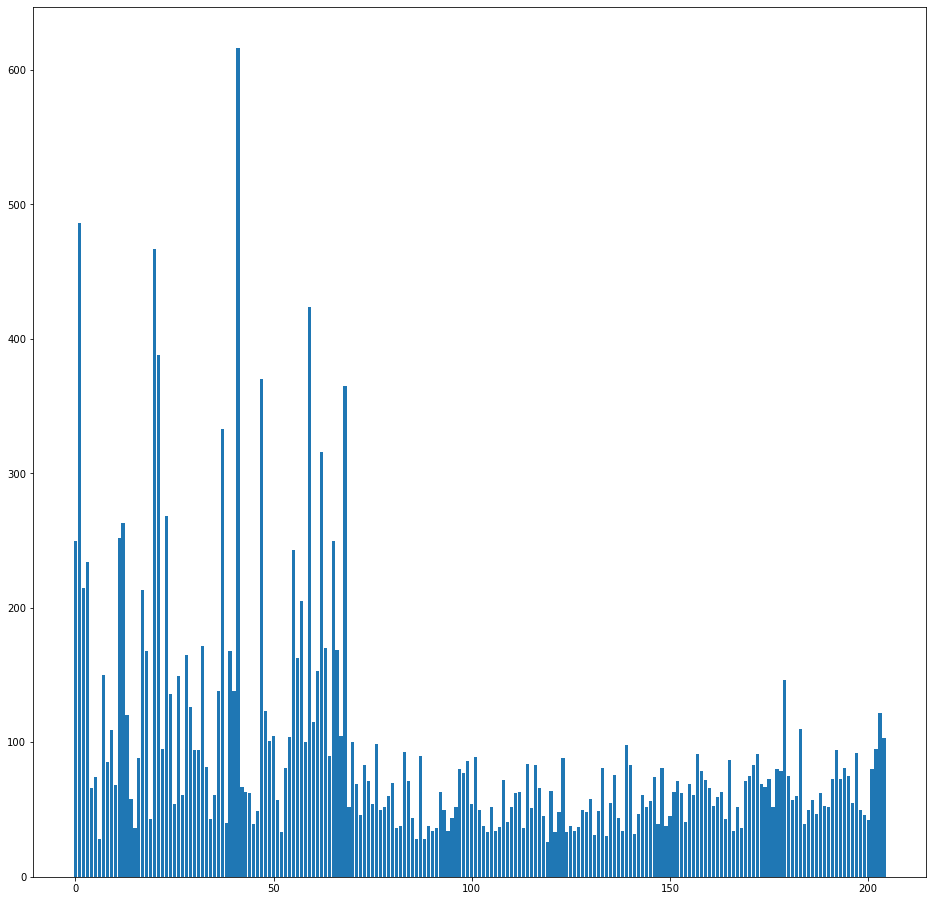

In [192]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,16))

ax.bar(x=list(range(pipe['model'].feature_importances_.shape[0])), height=pipe['model'].feature_importances_)

In [193]:
np.sort(pipe['model'].feature_importances_)

array([ 26,  28,  28,  28,  30,  31,  32,  33,  33,  33,  33,  34,  34,
        34,  34,  34,  34,  36,  36,  36,  36,  36,  37,  37,  38,  38,
        38,  38,  38,  39,  39,  39,  40,  41,  41,  42,  43,  43,  43,
        44,  44,  44,  45,  45,  46,  46,  47,  47,  48,  48,  49,  49,
        50,  50,  50,  50,  50,  50,  51,  52,  52,  52,  52,  52,  52,
        52,  52,  52,  53,  53,  54,  54,  54,  55,  55,  56,  57,  57,
        57,  58,  58,  59,  60,  60,  61,  61,  61,  61,  62,  62,  62,
        62,  63,  63,  63,  63,  63,  64,  66,  66,  66,  67,  67,  68,
        69,  69,  69,  70,  71,  71,  71,  71,  72,  72,  73,  73,  73,
        74,  74,  75,  75,  75,  76,  77,  79,  79,  80,  80,  80,  81,
        81,  81,  81,  82,  83,  83,  83,  83,  84,  85,  86,  87,  88,
        88,  89,  90,  90,  91,  91,  92,  93,  94,  94,  94,  95,  95,
        98,  99, 100, 100, 101, 103, 104, 105, 105, 109, 110, 115, 120,
       122, 123, 126, 136, 138, 138, 146, 149, 150, 153, 163, 16

In [194]:
# significant columns
FI_COLS = pipe['model'].feature_importances_>31

In [195]:
FI_COLS.shape

(205,)

In [80]:
pipe.fit(pd.concat([df_train[TIME_SERIES], df_fft[FFT_COLS]], axis=1), df_train.crop)

Pipeline(steps=[('scaler',
                 Scaler(features=RangeIndex(start=67, stop=135, step=1))),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [84]:
df_test_path=f'{PROC_DIR}test_lin_interp.csv'
fft_obj = CustomFFT(df_test_path)
# в fft_test_amp добавлены фазы во вторую половину
fft_test_freq, fft_test_amp = fft_obj.transform(_)

df_test_fft = pd.DataFrame(fft_test_amp)
FFT_COLS = df_fft.columns

In [85]:
df_test_fft.shape

(2071, 135)

In [86]:
y_pred = pipe.predict(pd.concat([df_test[TIME_SERIES], df_test_fft[FFT_COLS]], axis=1))

In [87]:
# Scaler + LGBM на ALL_COLS выдало 0.966
#Сохраняем в csv файл
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_pred.astype(int))}).to_csv(
    f'{OUT_DIR}ts_and_fft_cols_lgbm_scaler.csv', sep=',', index=None)
# на prod 0.968

In [ ]:
# TS + FFT ALL data 0.963; то же, что и только для TS data

In [509]:
# 0.85 только для фазы и LGBM

In [ ]:
# 0.849 только для фазы и XGBoost

In [ ]:
# 0.866 только для фазы и CatBoost
# 0.86 фаза, std_scaler, CatBoost, меньше

# Усреднённые спектры и фазы по категориям полей
## Вторая половина графика - это фазы

In [200]:
# Первая половина столбцов - амплитуды, вторая - их соответствующие фазы.
df_fft_phase = pd.concat([df_fft[FFT_COLS], df_train[TARGET]], axis=1)
df_fft_phase

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,crop
0,0.2784,0.1730,0.0833,0.0261,0.0626,0.0811,0.1083,0.0946,0.0668,0.0546,...,-0.7027,0.6084,-2.9806,-0.5441,1.1041,-0.3485,1.8115,2.9336,-2.0709,3
1,0.2986,0.1504,0.0281,0.0172,0.0574,0.0425,0.0857,0.0360,0.0142,0.0191,...,1.1523,2.3010,-2.2288,0.2514,-3.0180,0.5761,-2.7603,-1.0403,-2.6436,4
2,0.2600,0.1958,0.0299,0.0534,0.0376,0.0883,0.1140,0.0633,0.0065,0.0151,...,2.5420,-0.8100,-2.8272,-0.3420,2.5823,-0.3298,2.7584,1.9209,-2.7120,2
3,0.2729,0.1629,0.0601,0.1042,0.1000,0.0651,0.0816,0.0558,0.1104,0.0245,...,-2.1366,-0.1128,2.8491,0.1822,-3.0913,0.6504,-1.0267,-2.6676,2.7844,5
4,0.2749,0.2514,0.1388,0.0721,0.0810,0.0435,0.0898,0.0850,0.0733,0.0356,...,-3.0848,0.5323,3.0576,-1.0155,2.3435,0.1904,1.8743,2.7764,-2.0937,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,0.3007,0.2467,0.1480,0.0607,0.0369,0.0820,0.0967,0.0810,0.0579,0.0399,...,-2.5268,-0.6992,-2.9679,-0.4429,2.3857,0.7549,1.7411,2.7383,-1.9692,6
4826,0.3592,0.3011,0.1260,0.0962,0.0622,0.0752,0.1406,0.0808,0.0689,0.0294,...,-2.2732,-0.1077,3.0859,-0.2871,2.5308,0.1970,2.3244,2.9171,-2.1937,6
4827,0.3333,0.2210,0.0325,0.0197,0.0673,0.0384,0.1971,0.1591,0.0234,0.0823,...,-2.6771,-1.7574,-2.7603,-0.5247,-2.7713,0.6031,-2.4977,-2.8722,-1.9522,6
4828,0.3035,0.1432,0.0390,0.0691,0.0915,0.0736,0.0553,0.0658,0.0909,0.0274,...,-1.5649,-0.0157,-2.9680,-0.5391,1.1568,-0.9133,-1.1239,0.3393,3.0551,5


In [201]:
df_fft_phase_avg = df_fft_phase.groupby('crop').mean()
df_fft_phase_avg

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
crop,,,,,,,,,,,,,,,,,,,,,
0,0.3088,0.1928,0.0928,0.0457,0.0743,0.0772,0.1018,0.0859,0.0516,0.0479,...,1.1407,-1.6210,-0.0301,-0.1337,-0.1218,1.6419,0.2452,0.6768,1.6535,-2.2900
1,0.3078,0.1685,0.0719,0.0597,0.0771,0.0480,0.0632,0.1180,0.0770,0.0493,...,0.1411,-0.8585,-0.4777,1.0388,-0.4318,-0.1295,-0.4816,-0.8716,1.4080,-2.1292
2,0.2968,0.1922,0.0619,0.0485,0.0831,0.1051,0.0902,0.0735,0.0571,0.0467,...,1.4034,-1.2861,-0.0345,1.6916,-0.4645,1.9507,-0.1823,0.8303,1.0276,-2.2335
3,0.3001,0.1410,0.0591,0.0726,0.0551,0.0573,0.0649,0.1088,0.0729,0.0509,...,0.0799,-1.2512,0.6068,1.1425,0.0202,1.0286,-0.6125,-1.5677,0.1138,-1.9600
4,0.3077,0.2147,0.0861,0.0583,0.0757,0.0762,0.0724,0.0773,0.0614,0.0492,...,1.0837,-1.5699,0.1561,0.5048,-0.1862,1.6362,0.1673,1.0543,1.6670,-2.2389
5,0.2966,0.1433,0.0589,0.0871,0.0654,0.0725,0.0718,0.0743,0.0905,0.0436,...,0.6869,-1.0791,-0.2837,1.3309,-0.2993,1.2415,-0.2999,-1.0687,-0.0175,0.3536
6,0.3130,0.1986,0.0852,0.0512,0.0688,0.0779,0.0993,0.0949,0.0474,0.0524,...,1.2036,-1.8217,-0.0788,-0.6590,-0.2296,1.0430,0.0457,0.1830,1.3254,-2.1463


In [202]:
# Ещё раз усредняем до одного ряда
df_fft_phase_avg_single = df_fft_phase_avg.mean()
df_fft_phase_avg_single

0      0.3044
1      0.1787
2      0.0737
3      0.0605
4      0.0714
        ...  
130    1.2018
131   -0.1597
132   -0.1091
133    1.0254
134   -1.8063
Length: 135, dtype: float64

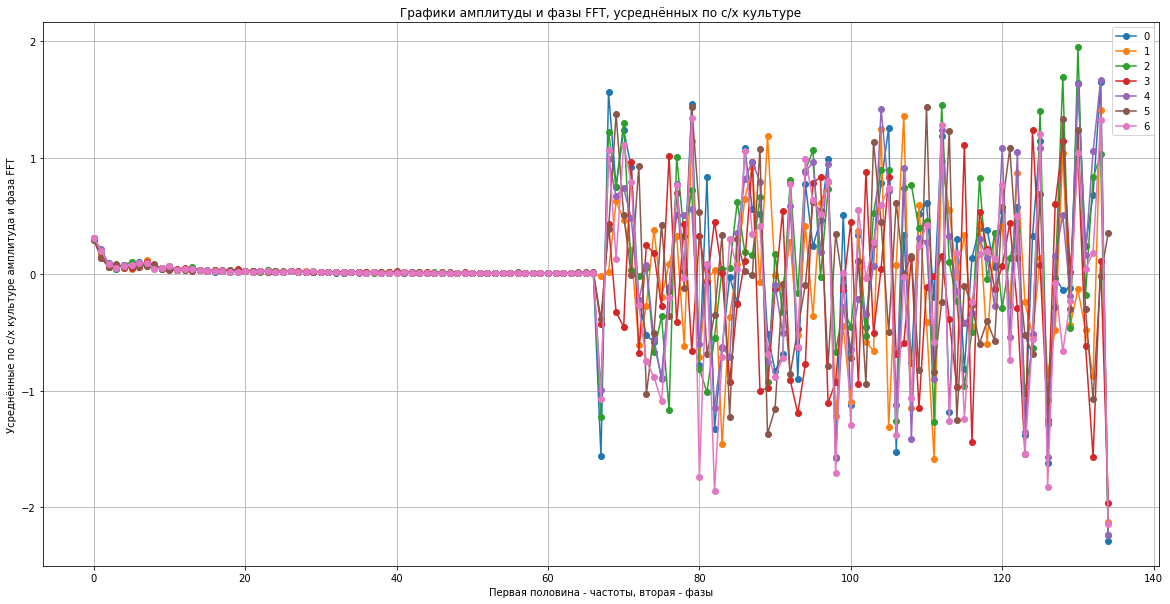

In [414]:
fig, ax = plt.subplots(figsize=(20,10))

for crop in range(7):
    df_fft_phase_avg.iloc[crop, :].plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Первая половина - частоты, вторая - фазы')
ax.set_ylabel('Усреднённые по с/х культуре амплитуда и фаза FFT')
ax.set_title('Графики амплитуды и фазы FFT, усреднённых по с/х культуре')
fig.savefig(OUT_DIR + 'FFT_phase_avg.png')

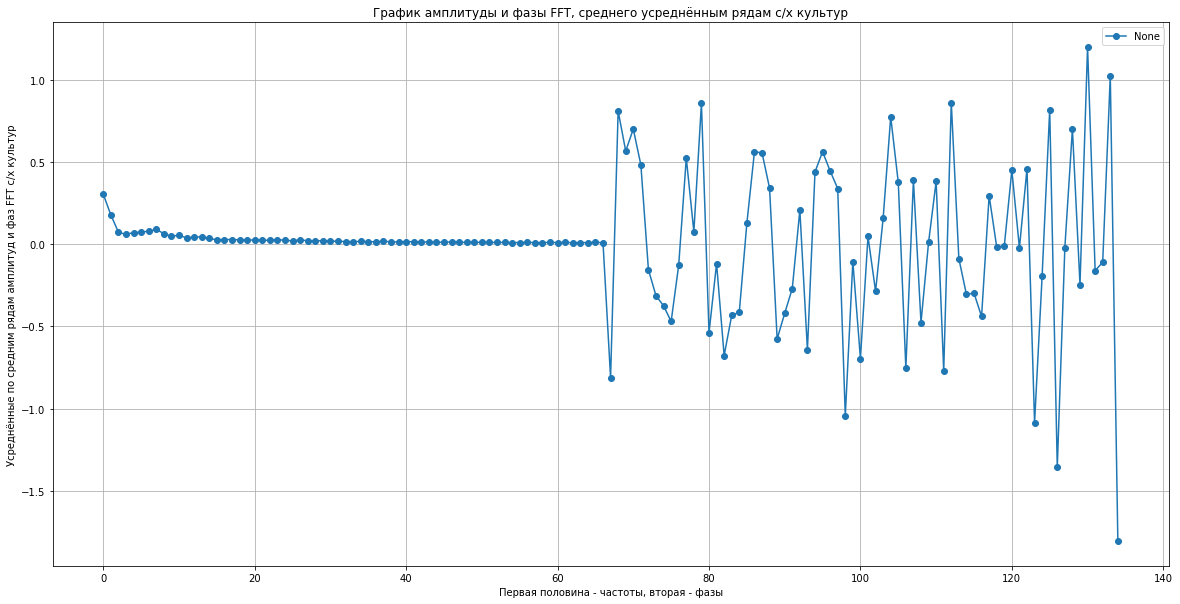

In [204]:
fig, ax = plt.subplots(figsize=(20,10))

df_fft_phase_avg_single.plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Первая половина - частоты, вторая - фазы')
ax.set_ylabel('Усреднённые по средним рядам амплитуд и фаз FFT с/х культур')
ax.set_title('График амплитуды и фазы FFT, среднего усреднённым рядам с/х культур')
fig.savefig(OUT_DIR + 'FFT_phase_avg_single.png')

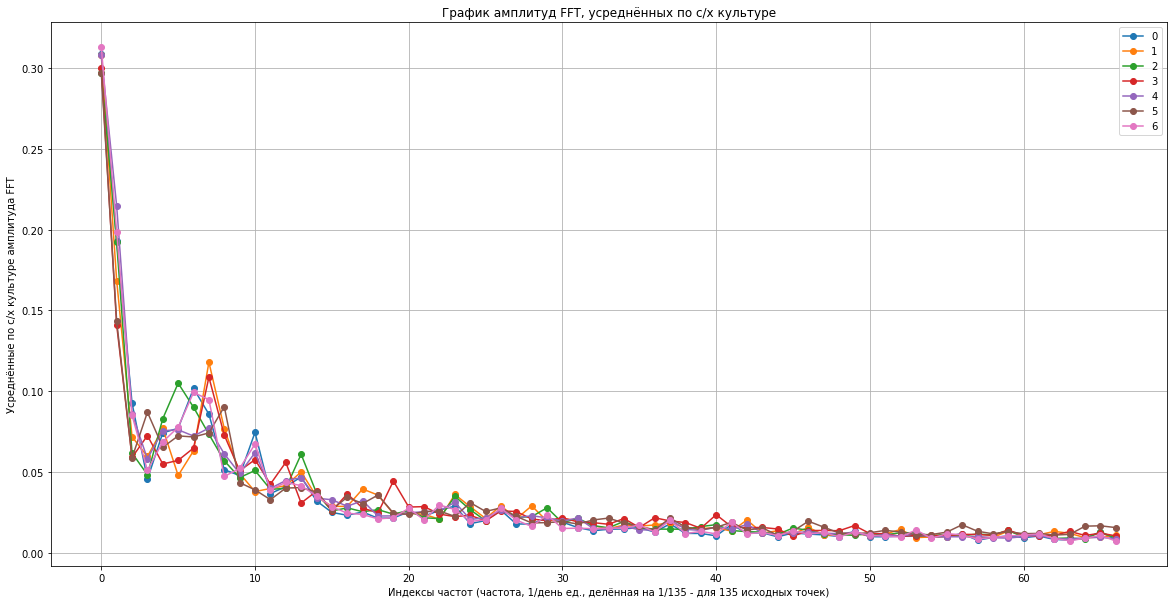

In [416]:
fig, ax = plt.subplots(figsize=(20,10))

for crop in range(7):
    df_fft_phase_avg.iloc[crop, :67].plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_ylabel('Усреднённые по с/х культуре амплитуда FFT')
ax.set_title('График амплитуд FFT, усреднённых по с/х культуре')
fig.savefig(OUT_DIR + 'FFT_amp_avg.png')

Text(0.5, 1.0, 'График амплитуд FFT, усреднённых по с/х культуре')

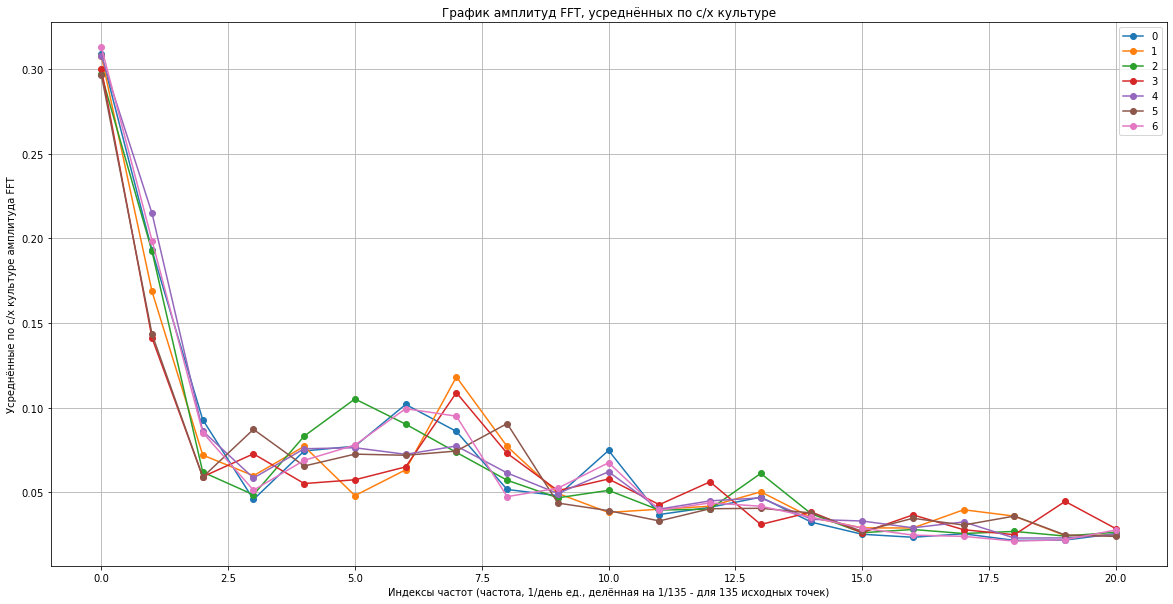

In [408]:
# Попытка выделить новые переменные-фичи
fig, ax = plt.subplots(figsize=(20,10))

for crop in range(7):
    df_fft_phase_avg.iloc[crop, 0:21].plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_ylabel('Усреднённые по с/х культуре амплитуда FFT')
ax.set_title('График амплитуд FFT, усреднённых по с/х культуре')

Text(0.5, 1.0, 'График амплитуд FFT, усреднённых по с/х культуре')

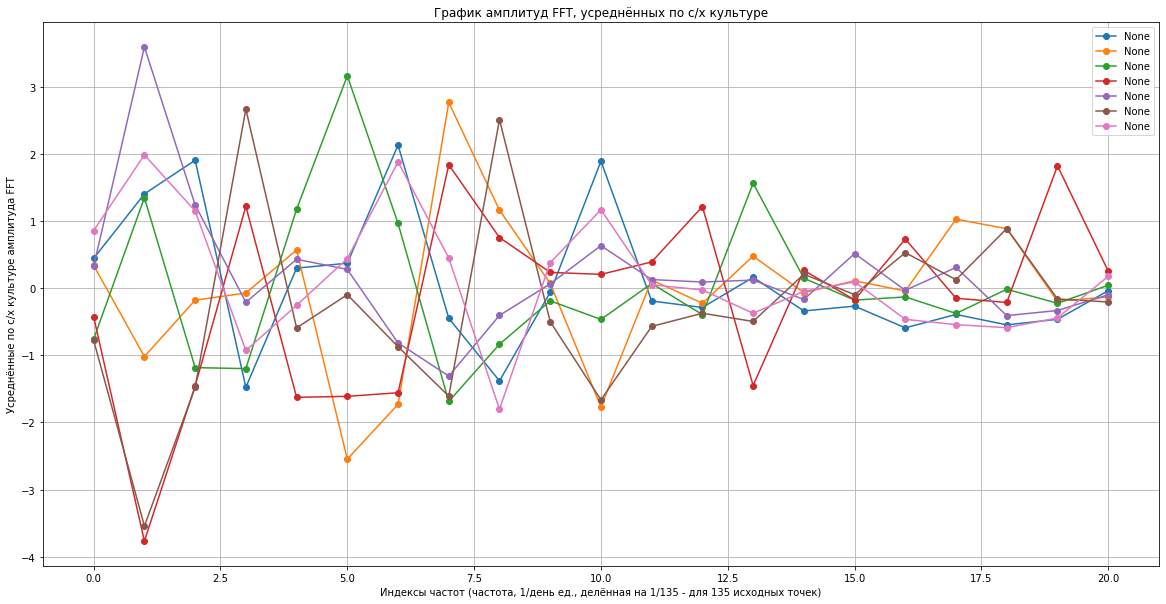

In [410]:
# Попытка выделить новые переменные-фичи
fig, ax = plt.subplots(figsize=(20,10))

for crop in range(7):
    (100*df_fft_phase_avg.iloc[crop, :21]-100*df_fft_phase_avg_single.iloc[:65]).plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_ylabel('Усреднённые по с/х культуре амплитуда FFT')
ax.set_title('График амплитуд FFT, усреднённых по с/х культуре')

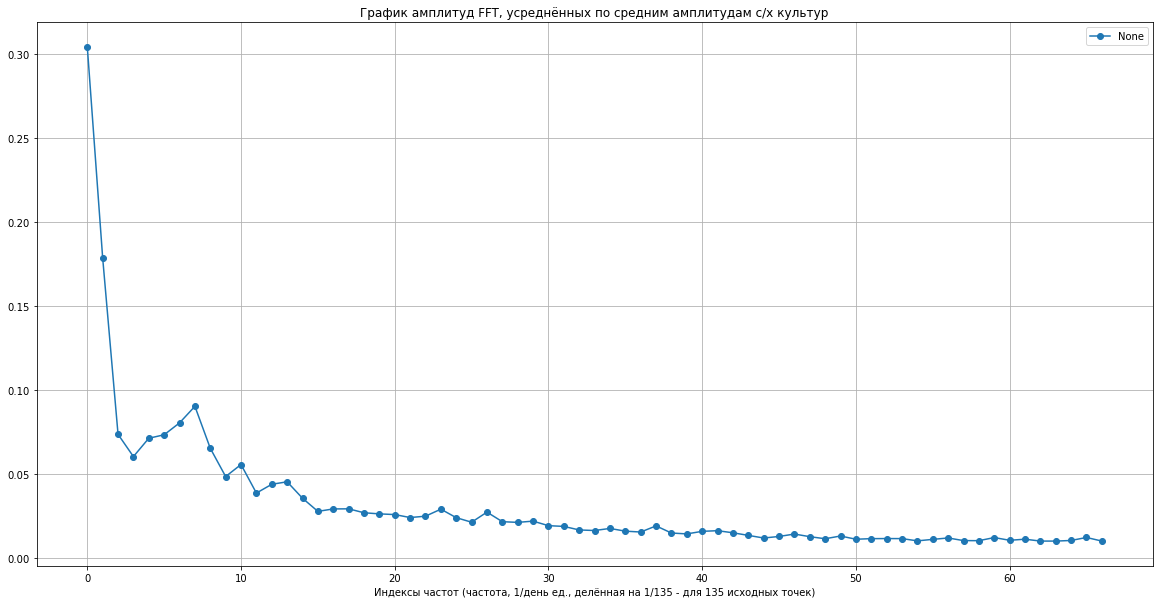

In [207]:
fig, ax = plt.subplots(figsize=(20,10))

df_fft_phase_avg_single.iloc[:67].plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_title('График амплитуд FFT, усреднённых по средним амплитудам с/х культур')
fig.savefig(OUT_DIR + 'FFT_amp_avg_single.png')

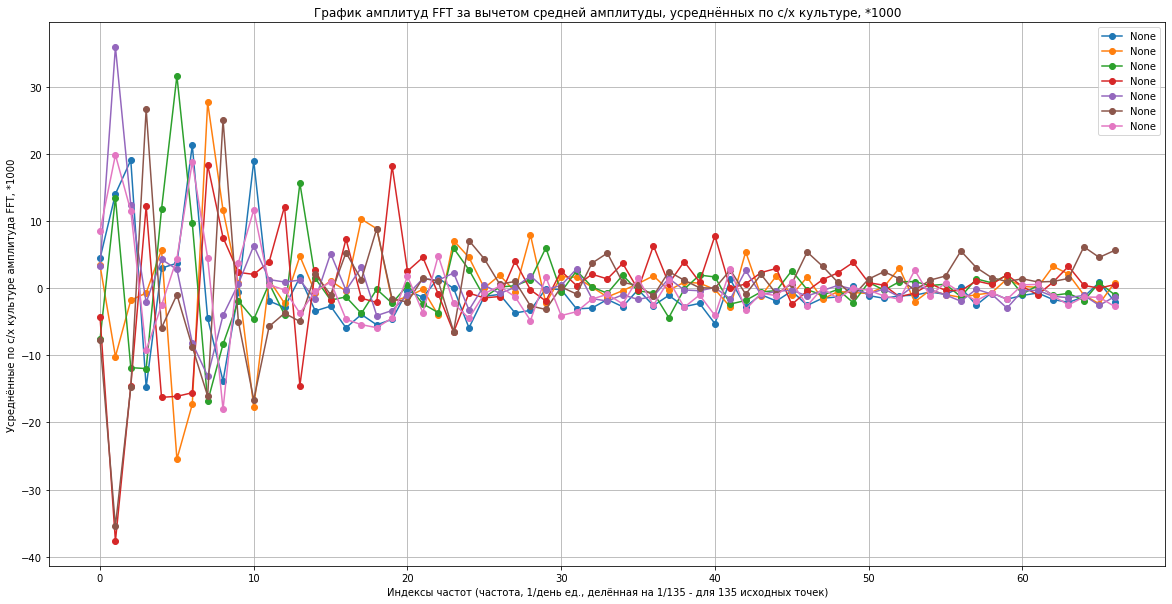

In [217]:
fig, ax = plt.subplots(figsize=(20,10))

for crop in range(7):
    (1000*df_fft_phase_avg.iloc[crop, :67]-1000*df_fft_phase_avg_single).plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_ylabel('Усреднённые по с/х культуре амплитуда FFT, *1000')
ax.set_title('График амплитуд FFT за вычетом средней амплитуды, усреднённых по с/х культуре, *1000')
fig.savefig(OUT_DIR + 'FFT_amp_avg_minus_avg_single.png')

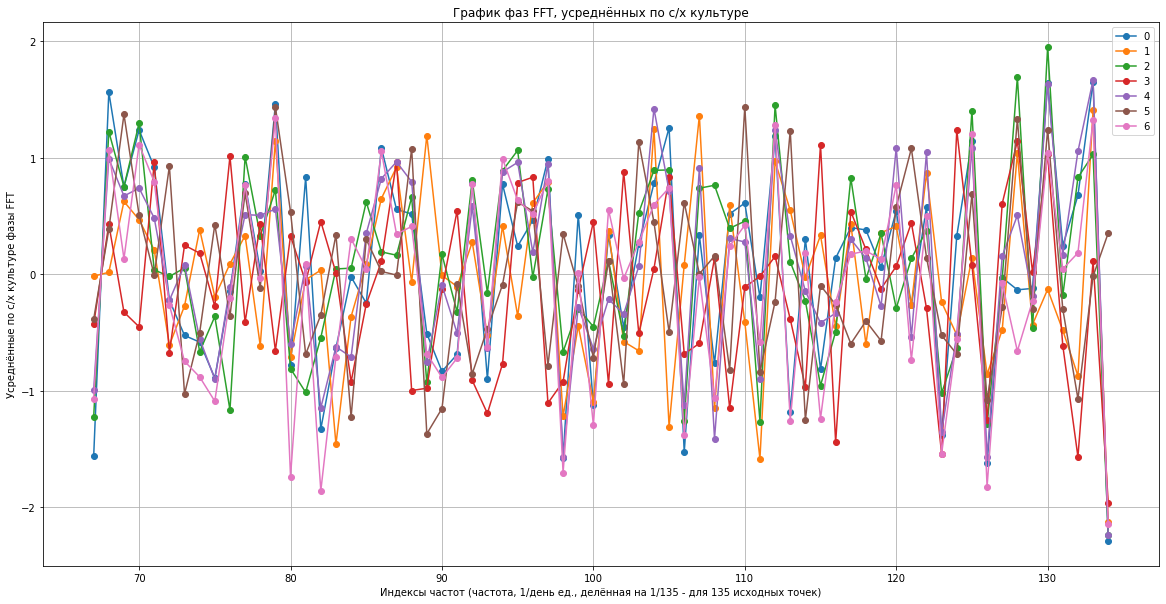

In [417]:
fig, ax = plt.subplots(figsize=(20,10))

for crop in range(7):
    df_fft_phase_avg.iloc[crop, 67:].plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_ylabel('Усреднённые по с/х культуре фазы FFT')
ax.set_title('График фаз FFT, усреднённых по с/х культуре')
fig.savefig(OUT_DIR + 'FFT_phase_avg.png')

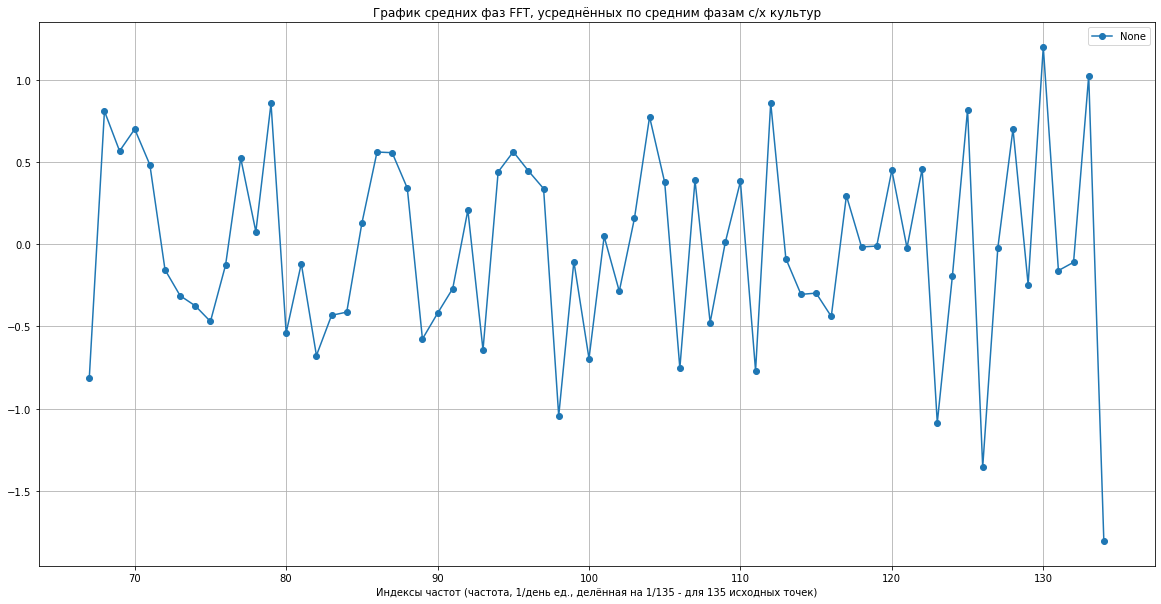

In [218]:
fig, ax = plt.subplots(figsize=(20,10))

df_fft_phase_avg_single.iloc[67:].plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_title('График средних фаз FFT, усреднённых по средним фазам с/х культур')
fig.savefig(OUT_DIR + 'FFT_phase_avg_single.png')

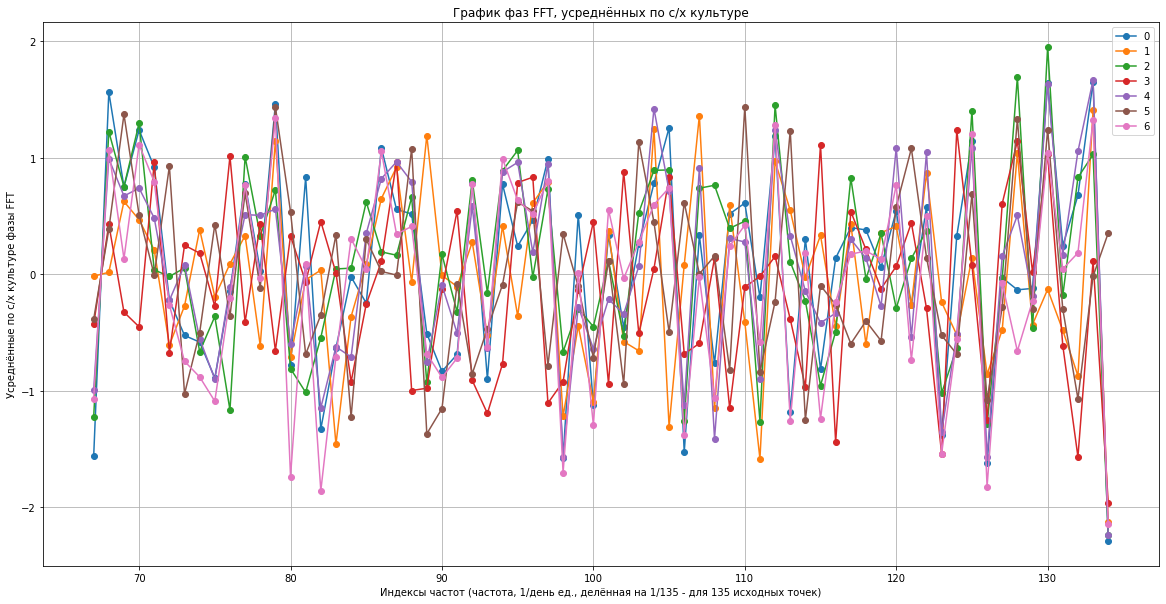

In [219]:
fig, ax = plt.subplots(figsize=(20,10))

for crop in range(7):
    df_fft_phase_avg.iloc[crop, 67:].plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_ylabel('Усреднённые по с/х культуре фазы FFT')
ax.set_title('График фаз FFT, усреднённых по с/х культуре')
fig.savefig(OUT_DIR + 'FFT_phase_avg.png')

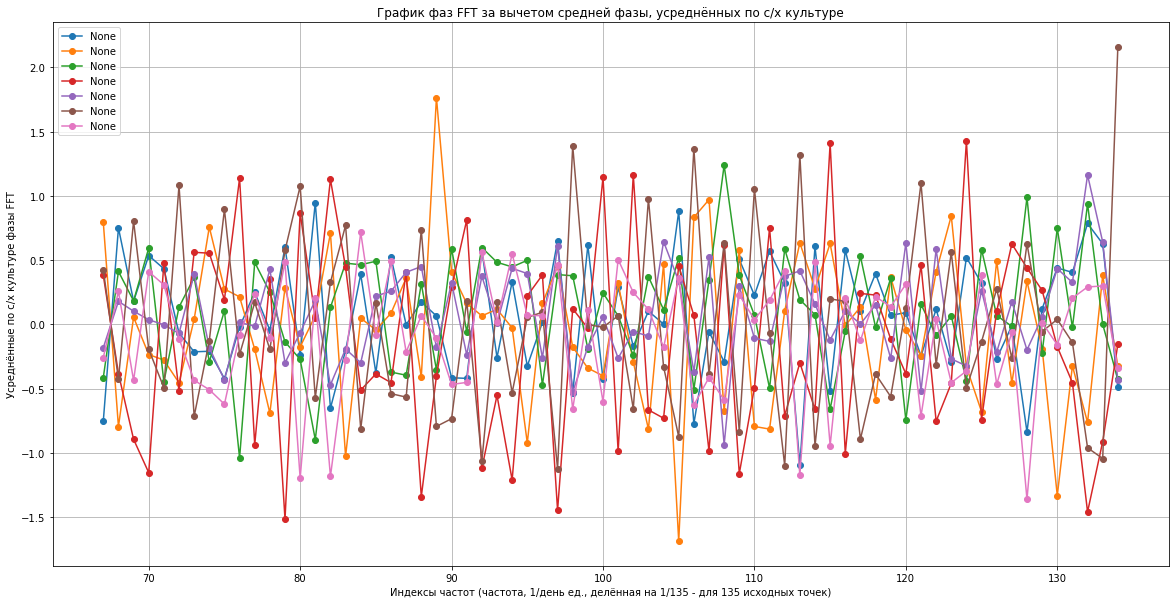

In [220]:
fig, ax = plt.subplots(figsize=(20,10))

for crop in range(7):
    (df_fft_phase_avg.iloc[crop, 67:]-df_fft_phase_avg_single.iloc[67:]).plot(marker='o', fig=fig, ax=ax)

ax.legend()
ax.grid()
ax.set_xlabel('Индексы частот (частота, 1/день ед., делённая на 1/135 - для 135 исходных точек)')
ax.set_ylabel('Усреднённые по с/х культуре фазы FFT')
ax.set_title('График фаз FFT за вычетом средней фазы, усреднённых по с/х культуре')
fig.savefig(OUT_DIR + 'FFT_phase_avg_minus_avg_single.png')

# Посмотреть сильно в противофазе
# Посмотреть сильно отличающихся по амплитуде
# Возможно новые фичи!

## Ищем макс. разброс от среднего по всем культурам для определения возможно новых переменных-фич.

In [23]:
# Проверка отрицательных и 0

In [34]:
(df_train[TIME_SERIES]>=1).sum().sum()

0

In [35]:
(df_test[TIME_SERIES]>=1).sum().sum()

0

In [38]:
(df_train[TIME_SERIES]<0).sum().sum()

40

In [39]:
(df_test[TIME_SERIES]<0).sum().sum()

17

In [73]:
type(df_train[df_train[TIME_SERIES]<0].count())

pandas.core.series.Series

In [13]:
df_train.loc[(df_train[TIME_SERIES]<0).any(axis=1), TIME_SERIES]

,nd_mean_2021-04-15,nd_mean_2021-04-16,nd_mean_2021-04-18,nd_mean_2021-04-19,nd_mean_2021-04-20,nd_mean_2021-04-22,nd_mean_2021-04-23,nd_mean_2021-04-25,nd_mean_2021-04-26,nd_mean_2021-04-27,...,nd_mean_2021-07-29,nd_mean_2021-07-31,nd_mean_2021-08-01,nd_mean_2021-08-07,nd_mean_2021-08-10,nd_mean_2021-08-11,nd_mean_2021-08-12,nd_mean_2021-08-13,nd_mean_2021-08-23,nd_mean_2021-08-27
39,0.0249,0.1334,1.9779e-01,0.2454,0.0809,0.0012,0.0367,0.1431,0.2503,0.0906,...,0.7524,0.0178,0.6633,0.0076,0.0518,0.0571,0.5065,0.0072,0.0000,0.0026
189,0.0329,0.1502,-2.4201e-02,0.2571,0.0106,0.0746,0.0031,0.0912,0.2150,0.1521,...,0.4682,0.3128,0.4459,0.4268,0.1920,0.1023,0.0010,0.0000,0.0414,0.0863
752,0.1479,0.0177,1.7563e-01,0.0000,0.0699,0.0660,0.0000,0.2174,0.1067,0.1366,...,0.6395,0.0000,0.0024,0.0443,0.0248,0.0463,0.3159,0.1745,0.0314,0.0000
874,0.2868,0.0661,-1.8030e-03,0.2190,0.0985,0.1266,0.2546,0.0162,0.2040,0.0000,...,0.3594,0.0188,0.5030,0.0329,0.1681,0.0931,0.0024,0.3816,0.0690,0.0000
922,0.1805,0.0360,-1.1486e-02,0.2216,0.0384,0.2726,0.1233,0.0884,0.1092,0.0142,...,0.5124,0.4709,0.5473,0.4704,0.1648,0.0656,0.4448,0.0193,0.1804,0.1018
999,0.0458,0.0358,5.8398e-02,0.2399,0.0000,0.0566,-0.0081,0.3257,0.0351,0.1308,...,0.7696,0.0996,0.8089,0.0000,0.2097,0.0646,0.7283,0.2122,0.1823,0.0000
1028,0.0836,0.2237,1.7653e-01,0.0000,0.2178,0.4292,0.0664,0.0372,0.0000,-0.0038,...,0.8151,0.5376,0.7737,0.1408,0.1908,0.0034,0.7535,0.0457,0.7513,0.0876
1098,0.0680,0.0000,6.9549e-02,0.0000,0.0448,0.3780,0.0000,0.0000,0.0946,-0.0062,...,0.7975,0.4985,0.7437,0.0663,0.2188,0.0000,0.7975,0.0622,0.7229,0.0991
1144,0.0012,0.2175,1.0241e-01,0.1901,0.1665,0.0289,0.2039,0.0000,0.0000,0.0000,...,0.8076,0.8407,0.1736,0.0000,0.0000,0.0610,0.4833,0.0000,0.0021,0.2376
1192,0.0529,0.3243,4.1997e-02,0.2482,0.0599,0.0485,0.0758,0.3248,0.3330,0.2145,...,0.1295,-0.0070,0.2375,0.7112,0.1478,0.6143,0.6801,0.0316,0.0437,0.1213


In [16]:
uniqueValsList = list(np.unique(np.array(df_train.loc[(df_train[TIME_SERIES]<0).any(axis=1), TIME_SERIES])))
uniqueValsList

[-0.0455028112336066,
 -0.0299746970168213,
 -0.0242013558745384,
 -0.0181009318042812,
 -0.0139981013937638,
 -0.0131127070635557,
 -0.0120244578768809,
 -0.0118968933820724,
 -0.011486486531794,
 -0.0114008263295583,
 -0.0100956428796052,
 -0.0098023046048851,
 -0.0094793660183788,
 -0.0094736318385963,
 -0.0081478337841955,
 -0.0073950059054004,
 -0.0070031055841933,
 -0.0061753806658089,
 -0.005568187304248,
 -0.0051577997104899,
 -0.0047008204273879,
 -0.0041203380933809,
 -0.0037817339242626,
 -0.0035851568086351,
 -0.0031825574876683,
 -0.0030742050478996,
 -0.0029196717778125,
 -0.0024501970037817,
 -0.0019808015786111,
 -0.0018030049977824,
 -0.001781912642858,
 -0.0014119664316668,
 -0.0011131029204751,
 -0.000863836830217,
 -0.0006530059267711,
 -0.0005448442160481,
 -0.0003699300755351,
 -0.0003376419969133,
 -7.526153058279306e-05,
 0.0,
 0.0001449132015785,
 0.0001854214273641,
 0.0007172961698536,
 0.000811339197481,
 0.0009559764250231,
 0.0010846080791316,
 0.001147691

In [48]:
zeros = df_train[TIME_SERIES].apply(lambda row: sum(row==0), axis=1).sort_values(ascending=False)
zeros.name='num_zeros'
print(zeros.name)
zeros_idx = zeros.index
zeros

num_zeros


1148    20
1479    19
1204    19
768     18
2905    18
        ..
168      2
1528     1
3004     1
491      1
1133     1
Name: num_zeros, Length: 4830, dtype: int64

In [51]:
num_zeros_by_crop = pd.concat([zeros, df_train.loc[zeros_idx, 'crop']], axis=1)
num_zeros_by_crop

,num_zeros,crop
1148,20,1
1479,19,2
1204,19,3
768,18,3
2905,18,3
...,...,...
168,2,3
1528,1,2
3004,1,5
491,1,2


In [53]:
num_zeros_by_crop.groupby('crop').sum('num_zeros')

,num_zeros
crop,
0,6057
1,6425
2,6232
3,5558
4,6076
5,5389
6,5566


<AxesSubplot:xlabel='crop'>

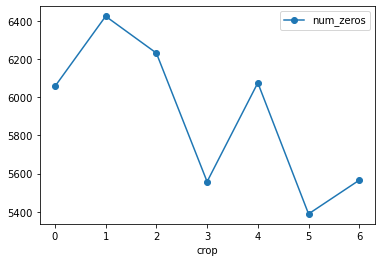

In [55]:
num_zeros_by_crop.groupby('crop').sum('num_zeros').plot(marker='o')

In [36]:
(df_train[TIME_SERIES]==0).sum().sum()

41303

In [37]:
(df_test[TIME_SERIES]==0).sum().sum()

17831

# Корреляции к среднему по с/х культуре среднему

In [497]:
from scipy.stats.stats import pearsonr
from sklearn.metrics import recall_score

def corr_to_mean(df_fft_phase=df_fft_phase, df_fft_phase_avg=df_fft_phase_avg,
                 out_file=f'{OUT_DIR}/fft_corr_avg_out.only_ampl.csv'):
    #print(df_fft_phase.shape[0])
    ts_corr_matrix = np.zeros([df_fft_phase.shape[0], 7])
    #print(ts_corr_matrix.shape)
    
    for idx, row in enumerate(np.array(df_fft_phase.iloc[:, :-1])):
        #print(idx, row)
        for crop, ts_crop_avg in enumerate(np.array(df_fft_phase_avg.iloc[:, :67])):
            #print(row.shape)
            #print(ts_crop_avg.shape)
            #print(crop, ts_crop_avg)
            #rol = np.array(pd.Series(row).rolling(window=4, min_periods=2, center=True).mean())
            ts_corr_matrix[idx, crop] = pearsonr(row, ts_crop_avg)[0]


    #print(ts_corr_matrix)
    crops_from_r = np.argmax(ts_corr_matrix, axis=1)
    #print(crops_from_r)
    
    print('\nrecall score:', recall_score(crops_from_r, np.array(df_fft_phase.crop), average='macro', zero_division=True))

    #print(crops_from_r)
    
    pd.DataFrame({'id': df_train.id, 'crop': np.squeeze(crops_from_r.astype(int))}).to_csv(
        out_file, sep=',', index=None)

In [462]:
corr_to_mean()


recall score: 0.6873940800647501


In [ ]:
# Для полного набора всего 0.687

In [472]:
corr_to_mean(df_fft_phase.iloc[:, 67:])


recall score: 0.6833053784407795


In [ ]:
# Только по фазе почти такая же точность как для и амплитуды и фазы!

In [492]:
df_fft_phase

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,crop
0,0.2784,0.1730,0.0833,0.0261,0.0626,0.0811,0.1083,0.0946,0.0668,0.0546,...,-0.7027,0.6084,-2.9806,-0.5441,1.1041,-0.3485,1.8115,2.9336,-2.0709,3
1,0.2986,0.1504,0.0281,0.0172,0.0574,0.0425,0.0857,0.0360,0.0142,0.0191,...,1.1523,2.3010,-2.2288,0.2514,-3.0180,0.5761,-2.7603,-1.0403,-2.6436,4
2,0.2600,0.1958,0.0299,0.0534,0.0376,0.0883,0.1140,0.0633,0.0065,0.0151,...,2.5420,-0.8100,-2.8272,-0.3420,2.5823,-0.3298,2.7584,1.9209,-2.7120,2
3,0.2729,0.1629,0.0601,0.1042,0.1000,0.0651,0.0816,0.0558,0.1104,0.0245,...,-2.1366,-0.1128,2.8491,0.1822,-3.0913,0.6504,-1.0267,-2.6676,2.7844,5
4,0.2749,0.2514,0.1388,0.0721,0.0810,0.0435,0.0898,0.0850,0.0733,0.0356,...,-3.0848,0.5323,3.0576,-1.0155,2.3435,0.1904,1.8743,2.7764,-2.0937,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,0.3007,0.2467,0.1480,0.0607,0.0369,0.0820,0.0967,0.0810,0.0579,0.0399,...,-2.5268,-0.6992,-2.9679,-0.4429,2.3857,0.7549,1.7411,2.7383,-1.9692,6
4826,0.3592,0.3011,0.1260,0.0962,0.0622,0.0752,0.1406,0.0808,0.0689,0.0294,...,-2.2732,-0.1077,3.0859,-0.2871,2.5308,0.1970,2.3244,2.9171,-2.1937,6
4827,0.3333,0.2210,0.0325,0.0197,0.0673,0.0384,0.1971,0.1591,0.0234,0.0823,...,-2.6771,-1.7574,-2.7603,-0.5247,-2.7713,0.6031,-2.4977,-2.8722,-1.9522,6
4828,0.3035,0.1432,0.0390,0.0691,0.0915,0.0736,0.0553,0.0658,0.0909,0.0274,...,-1.5649,-0.0157,-2.9680,-0.5391,1.1568,-0.9133,-1.1239,0.3393,3.0551,5


In [498]:
corr_to_mean(pd.concat([df_fft_phase.iloc[:, :67], df_fft_phase.iloc[:, -1]], axis=1))


recall score: 0.5747575523382162


In [ ]:
# Только по амплитуде предсказал гораздо хуже. Всего 0.57

In [431]:
df_fft_phase.iloc[:, 67:]

,67,68,69,70,71,72,73,74,75,76,...,126,127,128,129,130,131,132,133,134,crop
0,-2.5044,2.5044,-0.2435,1.3901,1.9296,-2.8621,-1.7317,-0.5806,-1.4964,-2.0367,...,-0.7027,0.6084,-2.9806,-0.5441,1.1041,-0.3485,1.8115,2.9336,-2.0709,3
1,-3.0183,3.0183,-0.6055,0.9419,-0.0960,2.4337,2.9003,-0.5692,-2.1925,2.8029,...,1.1523,2.3010,-2.2288,0.2514,-3.0180,0.5761,-2.7603,-1.0403,-2.6436,4
2,-1.3357,1.3357,-2.0654,0.9282,1.9194,-1.7477,1.1077,-0.4971,-2.0943,-1.1168,...,2.5420,-0.8100,-2.8272,-0.3420,2.5823,-0.3298,2.7584,1.9209,-2.7120,2
3,1.1362,-1.1362,2.8182,0.4914,-2.2911,2.2617,-2.0414,2.8788,0.9360,-2.2531,...,-2.1366,-0.1128,2.8491,0.1822,-3.0913,0.6504,-1.0267,-2.6676,2.7844,5
4,-2.7189,2.7189,-1.0207,-1.4305,0.9932,-1.0470,-2.7287,-1.2613,2.2518,-0.5958,...,-3.0848,0.5323,3.0576,-1.0155,2.3435,0.1904,1.8743,2.7764,-2.0937,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4825,-1.5766,1.5766,0.9061,1.2124,2.3973,3.1116,-2.3367,-1.1844,-0.2813,-0.3195,...,-2.5268,-0.6992,-2.9679,-0.4429,2.3857,0.7549,1.7411,2.7383,-1.9692,6
4826,-1.9516,1.9516,1.1321,0.7416,2.9164,0.9245,-0.6536,-0.9738,-1.9238,-1.1656,...,-2.2732,-0.1077,3.0859,-0.2871,2.5308,0.1970,2.3244,2.9171,-2.1937,6
4827,-2.0842,2.0842,-2.2814,2.7162,2.6048,0.5566,2.6068,-1.2927,-2.8928,-0.6433,...,-2.6771,-1.7574,-2.7603,-0.5247,-2.7713,0.6031,-2.4977,-2.8722,-1.9522,6
4828,0.4208,-0.4208,-2.8402,0.1124,3.0345,0.6830,-1.8279,2.9906,0.8779,-2.9973,...,-1.5649,-0.0157,-2.9680,-0.5391,1.1568,-0.9133,-1.1239,0.3393,3.0551,5


<BarContainer object of 135 artists>

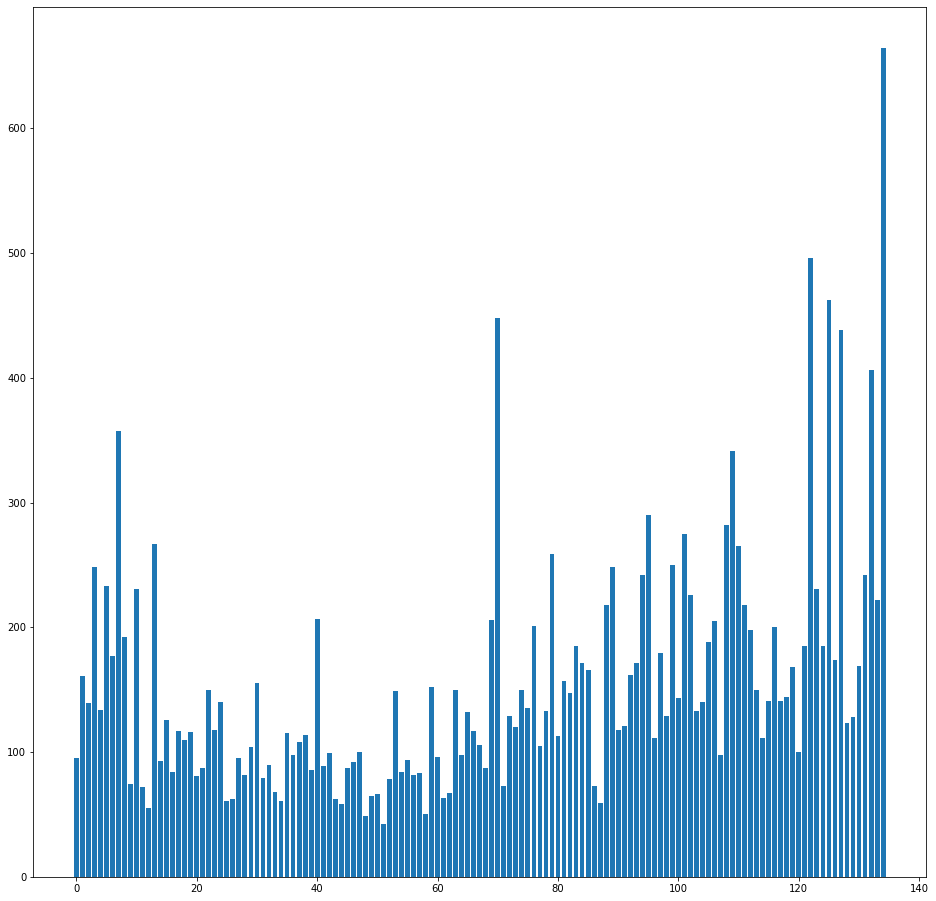

In [408]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,16))

ax.bar(x=list(range(pipe['model'].feature_importances_.shape[0])), height=pipe['model'].feature_importances_)

In [27]:
# 0.9631283040829245
pipe = Pipeline([
    ('std_scaler', CustomStandardScaler(TIME_SERIES)),
    ('model', CustomLightGBMClassifier(random_state=SEED))
])

pipe.fit(df_train[TIME_SERIES], df_train[TARGET])

Pipeline(steps=[('std_scaler',
                 CustomStandardScaler(features=Index(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-28', 'nd_mean_2021-04-29',
       'nd_mean_2021-04-30', 'nd_mean_2...
       'nd_mean_2021-07-13', 'nd_mean_2021-07-15', 'nd_mean_2021-07-17',
       'nd_mean_2021-07-20', 'nd_mean_2021-07-26', 'nd_mean_2021-07-27',
       'nd_mean_2021-07-29', 'nd_mean_2021-07-31', 'nd_mean_2021-08-01',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-10', 'nd_mean_2021-08-11',
       'nd_mean_2021-08-12', 'nd_mean_2021-08-13', 'nd_mean_2021-08-23',
       'nd_mean_2021-08-27'],
      dtype='object'))),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [719]:
y_pred = pipe.predict(df_test[TIME_SERIES])

In [720]:
#Сохраняем в csv файл
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_pred.astype(int))}).to_csv(
    f'{OUT_DIR}lgbm_pipe_2_std_scaler.csv', sep=',', index=None)

In [16]:
# Найденный по feature importance в другом kaggle notebook список дат
fi_date_list = [
                '05-15', '05-17', '08-01', '06-16', '08-13', '05-24', '07-04', '08-07', '07-17', '05-26', '07-27', '04-16',
                '06-09', '07-29', '06-27', '08-23', '06-12', '05-10', '06-13', '04-30', '07-15', '05-19', '04-29', '06-04',
                '08-11', '05-08', '04-19', '04-15', '05-07', '06-03', '04-18',
                '07-05', '06-28', '07-20', '07-26', '08-12', '05-29', '07-31', '06-02', '04-25', '05-03', '05-27', '06-07', '05-04', '08-10', '05-21',
                '05-01', '04-27', '06-18', '04-22', '06-19', '04-26', '05-16', '05-20', # fi_8
                '07-07', # fi_9
                '06-20', #fi_10
                #'04-28', #fi_11 видимо то же, что и fi_7 # fi_7
                #'07-13', 
                #'06-25', '05-02', '06-22', '06-06', '07-09', # fi_5
                #'07-08', '06-10', '06-05', '05-09', '08-27', '04-20', '04-23', # fi_6
               ]
fi_date_list[:5]

['05-15', '05-17', '08-01', '06-16', '08-13']

In [17]:
fi_cols = ['nd_mean_2021-'+dt for dt in fi_date_list]
fi_cols[:5]

['nd_mean_2021-05-15',
 'nd_mean_2021-05-17',
 'nd_mean_2021-08-01',
 'nd_mean_2021-06-16',
 'nd_mean_2021-08-13']

In [18]:
df_train[fi_cols].head(3)

,nd_mean_2021-05-15,nd_mean_2021-05-17,nd_mean_2021-08-01,nd_mean_2021-06-16,nd_mean_2021-08-13,nd_mean_2021-05-24,nd_mean_2021-07-04,nd_mean_2021-08-07,nd_mean_2021-07-17,nd_mean_2021-05-26,...,nd_mean_2021-05-01,nd_mean_2021-04-27,nd_mean_2021-06-18,nd_mean_2021-04-22,nd_mean_2021-06-19,nd_mean_2021-04-26,nd_mean_2021-05-16,nd_mean_2021-05-20,nd_mean_2021-07-07,nd_mean_2021-06-20
0,0.3583,0.2010,0.7549,0.0000,0.1268,0.0815,0.0141,0.0000,0.0000,0.3978,...,0.1218,0.0005,0.4121,0.0630,0.5070,0.1044,0.4841,0.1090,0.7070,0.4907
1,0.0311,0.5015,0.7062,0.0000,0.1749,0.0470,0.1943,0.1842,0.6769,0.4488,...,0.0474,0.1964,0.4922,0.0971,0.7086,0.1525,0.5195,0.1345,0.7090,0.6680
2,0.0028,0.5615,0.0000,0.7173,0.0906,0.2196,0.1357,0.3573,0.5435,0.0295,...,0.2302,0.1690,0.6493,0.1208,0.7409,0.0378,0.0000,0.0845,0.6481,0.6521


In [19]:
pipe = Pipeline([
    ('num_imputer', NeighborImputer(fi_cols)),
    ('scaler', Scaler(fi_cols)),
    ('rnd_coll_adder', RandomColumnAdder(fi_cols)),
    ('model', CustomLightGBMClassifier(random_state=SEED))
])

pipe.fit(X_train[fi_cols], y_train)

Pipeline(steps=[('num_imputer',
                 NeighborImputer(features=['nd_mean_2021-05-15',
                                           'nd_mean_2021-05-17',
                                           'nd_mean_2021-08-01',
                                           'nd_mean_2021-06-16',
                                           'nd_mean_2021-08-13',
                                           'nd_mean_2021-05-24',
                                           'nd_mean_2021-07-04',
                                           'nd_mean_2021-08-07',
                                           'nd_mean_2021-07-17',
                                           'nd_mean_2021-05-26',
                                           'nd_mean_2021-07-27',
                                           'nd_mean_2021-04-16',
                                           'nd_mean_2021-06-09',
                                           'nd_mean_2021-07-29'...
                                             'nd_mean_2021-06-12',
                                             'nd_mean_2021-05-10',
                                             'nd_mean_2021-06-13',
                                             'nd_mean_2021-04-30',
                                             'nd_mean_2021-07-15',
                                             'nd_mean_2021-05-19',
                                             'nd_mean_2021-04-29',
                                             'nd_mean_2021-06-04',
                                             'nd_mean_2021-08-11',
                                             'nd_mean_2021-05-08',
                                             'nd_mean_2021-04-19',
                                             'nd_mean_2021-04-15',
                                             'nd_mean_2021-05-07',
                                             'nd_mean_2021-06-03', ...])),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [20]:
from sklearn.metrics import recall_score, precision_score

y_pred = pipe.predict(X_test[fi_cols])
print('\n',recall_score(y_test, pred, average="macro", zero_division=0))


 0.9631283040829245


In [21]:
# 0.9650575107015477 с такими установками + fi cols
pipe = Pipeline([
    ('num_imputer', NeighborImputer(fi_cols)),
    ('scaler', Scaler(fi_cols)),
    ('rnd_coll_adder', RandomColumnAdder(fi_cols)),
    ('model', CustomLightGBMClassifier(random_state=SEED))
])

pipe.fit(df_train[fi_cols], df_train[TARGET])

Pipeline(steps=[('num_imputer',
                 NeighborImputer(features=['nd_mean_2021-05-15',
                                           'nd_mean_2021-05-17',
                                           'nd_mean_2021-08-01',
                                           'nd_mean_2021-06-16',
                                           'nd_mean_2021-08-13',
                                           'nd_mean_2021-05-24',
                                           'nd_mean_2021-07-04',
                                           'nd_mean_2021-08-07',
                                           'nd_mean_2021-07-17',
                                           'nd_mean_2021-05-26',
                                           'nd_mean_2021-07-27',
                                           'nd_mean_2021-04-16',
                                           'nd_mean_2021-06-09',
                                           'nd_mean_2021-07-29'...
                                             'nd_mean_2021-06-12',
                                             'nd_mean_2021-05-10',
                                             'nd_mean_2021-06-13',
                                             'nd_mean_2021-04-30',
                                             'nd_mean_2021-07-15',
                                             'nd_mean_2021-05-19',
                                             'nd_mean_2021-04-29',
                                             'nd_mean_2021-06-04',
                                             'nd_mean_2021-08-11',
                                             'nd_mean_2021-05-08',
                                             'nd_mean_2021-04-19',
                                             'nd_mean_2021-04-15',
                                             'nd_mean_2021-05-07',
                                             'nd_mean_2021-06-03', ...])),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [ ]:
y_pred = pipe.predict(df_test[TIME_SERIES])

In [734]:
#Сохраняем в csv файл
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_pred.astype(int))}).to_csv(
    f'{OUT_DIR}lgbm_pipe_3_min_max_scaler_fi.csv', sep=',', index=None)

In [469]:
# 0.9650575107015477 с такими установками
pipe = Pipeline([
    ('num_imputer', NeighborImputer(TIME_SERIES)),
    ('scaler', Scaler(TIME_SERIES)),
    ('rnd_coll_adder', RandomColumnAdder(TIME_SERIES)),
    ('model', CustomLightGBMClassifier(random_state=SEED))
])

pipe.fit(df_train[TIME_SERIES], df_train[TARGET])

Pipeline(steps=[('num_imputer',
                 NeighborImputer(features=Index(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-28', 'nd_mean_2021-04-29',
       'nd_mean_2021-04-30', 'nd_mean_2021-...
       'nd_mean_2021-07-13', 'nd_mean_2021-07-15', 'nd_mean_2021-07-17',
       'nd_mean_2021-07-20', 'nd_mean_2021-07-26', 'nd_mean_2021-07-27',
       'nd_mean_2021-07-29', 'nd_mean_2021-07-31', 'nd_mean_2021-08-01',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-10', 'nd_mean_2021-08-11',
       'nd_mean_2021-08-12', 'nd_mean_2021-08-13', 'nd_mean_2021-08-23',
       'nd_mean_2021-08-27'],
      dtype='object'))),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [470]:
from sklearn.metrics import recall_score, precision_score

pred = pipe.predict(df_train[TIME_SERIES])
# NOTE: на тех же данных! 1.0
print('\n',recall_score(df_train[TARGET], pred, average="macro", zero_division=0))


 1.0


In [474]:
y_pred = pipe.predict(df_test[TIME_SERIES])

In [478]:
#Сохраняем в csv файл
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_pred.astype(int))}).to_csv(
    f'{OUT_DIR}lgbm_pipe_1_min_max_scaler.csv', sep=',', index=None)

In [608]:
# 0.962528520254131
pipe = Pipeline([
    ('scaler', Scaler(TIME_SERIES)),
    ('model', CustomCatBoostClassifier(random_state=SEED, logging_level="Silent"))
])

pipe.fit(df_train[TIME_SERIES], df_train[TARGET])

Pipeline(steps=[('scaler',
                 Scaler(features=Index(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-28', 'nd_mean_2021-04-29',
       'nd_mean_2021-04-30', 'nd_mean_2021-05-01', 'nd_mea...
       'nd_mean_2021-07-20', 'nd_mean_2021-07-26', 'nd_mean_2021-07-27',
       'nd_mean_2021-07-29', 'nd_mean_2021-07-31', 'nd_mean_2021-08-01',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-10', 'nd_mean_2021-08-11',
       'nd_mean_2021-08-12', 'nd_mean_2021-08-13', 'nd_mean_2021-08-23',
       'nd_mean_2021-08-27'],
      dtype='object'))),
                ('model',
                 <__main__.CustomCatBoostClassifier object at 0x000002136136C6D0>)])

In [611]:
y_pred = pipe.predict(df_test[TIME_SERIES])

In [612]:
#Сохраняем в csv файл
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_pred.astype(int))}).to_csv(
    f'{OUT_DIR}catboost_pipe_1_min_max_scaler.csv', sep=',', index=None)

In [310]:
X_train, X_test, y_train, y_test = train_test_split(df_train[SIG_FEATURES], df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED, 
                                                    stratify=df_train[TARGET])

In [305]:
pipe = Pipeline([
    ('nan_masker', NanMaskEncoder(SIG_FEATURES)),
    ('linreg_imputer', LinRegImputer(SIG_FEATURES)),
    # Оставшиеся пропущенные значения заменяем на соседние
    ('num_imputer', NeighborImputer(SIG_FEATURES)),
    ('scaler', Scaler(SIG_FEATURES)),
    #('cat_imputer', Imputer(CATEGORICAL)),
    #('encoder', Encoder(CATEGORICAL)),
    #('rnd_coll_adder', RandomColumnAdder(TIME_SERIES)),
    #('model', RandomForestClassifier(random_state=SEED, n_estimators = 3))

    ('model', CustomLightGBMClassifier(random_state=SEED))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('nan_masker',
                 NanMaskEncoder(features=array(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-28', 'nd_mean_2021-04-29', 'nd_mean_2021-04-30',
       'nd_mean_2021-05-01', 'nd_mean_2021-05...
       'nd_mean_2021-07-15', 'nd_mean_2021-07-17', 'nd_mean_2021-07-20',
       'nd_mean_2021-07-26', 'nd_mean_2021-07-27', 'nd_mean_2021-07-29',
       'nd_mean_2021-07-31', 'nd_mean_2021-08-01', 'nd_mean_2021-08-07',
       'nd_mean_2021-08-10', 'nd_mean_2021-08-11', 'nd_mean_2021-08-12',
       'nd_mean_2021-08-13', 'nd_mean_2021-08-23', 'nd_mean_2021-08-27'],
      dtype=object))),
                ('model', CustomLightGBMClassifier(random_state=42))])

In [306]:
from sklearn.metrics import recall_score, precision_score

pred = pipe.predict(X_test)
print('\n',recall_score(y_test, pred, average="macro", zero_division=0))
#print(pipe)
#print(type(pred), pred.shape, pred)


 0.9240988420304352


In [265]:
dir(pipe)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_can_inverse_transform',
 '_can_transform',
 '_check_feature_names',
 '_check_fit_params',
 '_check_n_features',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_params',
 '_sk_visual_block_',
 '_validate_data',
 '_validate_names',
 '_validate_steps',
 'classe

In [282]:
dir(pipe['model'])

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_oob_predictions',
 '_estimator_type',
 '_get_oob_predictions',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score_and_attributes',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'ccp_alpha',
 'class_weight'

In [283]:
pipe['model'].feature_names_in_

array(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-28', 'nd_mean_2021-04-29',
       'nd_mean_2021-04-30', 'nd_mean_2021-05-01', 'nd_mean_2021-05-02',
       'nd_mean_2021-05-03', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07',
       'nd_mean_2021-05-08', 'nd_mean_2021-05-09', 'nd_mean_2021-05-10',
       'nd_mean_2021-05-15', 'nd_mean_2021-05-16', 'nd_mean_2021-05-17',
       'nd_mean_2021-05-19', 'nd_mean_2021-05-20', 'nd_mean_2021-05-21',
       'nd_mean_2021-05-24', 'nd_mean_2021-05-26', 'nd_mean_2021-05-27',
       'nd_mean_2021-05-29', 'nd_mean_2021-06-02', 'nd_mean_2021-06-03',
       'nd_mean_2021-06-04', 'nd_mean_2021-06-05', 'nd_mean_2021-06-06',
       'nd_mean_2021-06-07', 'nd_mean_2021-06-09', 'nd_mean_2021-06-10',
       'nd_mean_2021-06-12', 'nd_mean_2021-06-13', 

In [250]:
pipe['model'].feature_importances_.shape[0]

71

<BarContainer object of 71 artists>

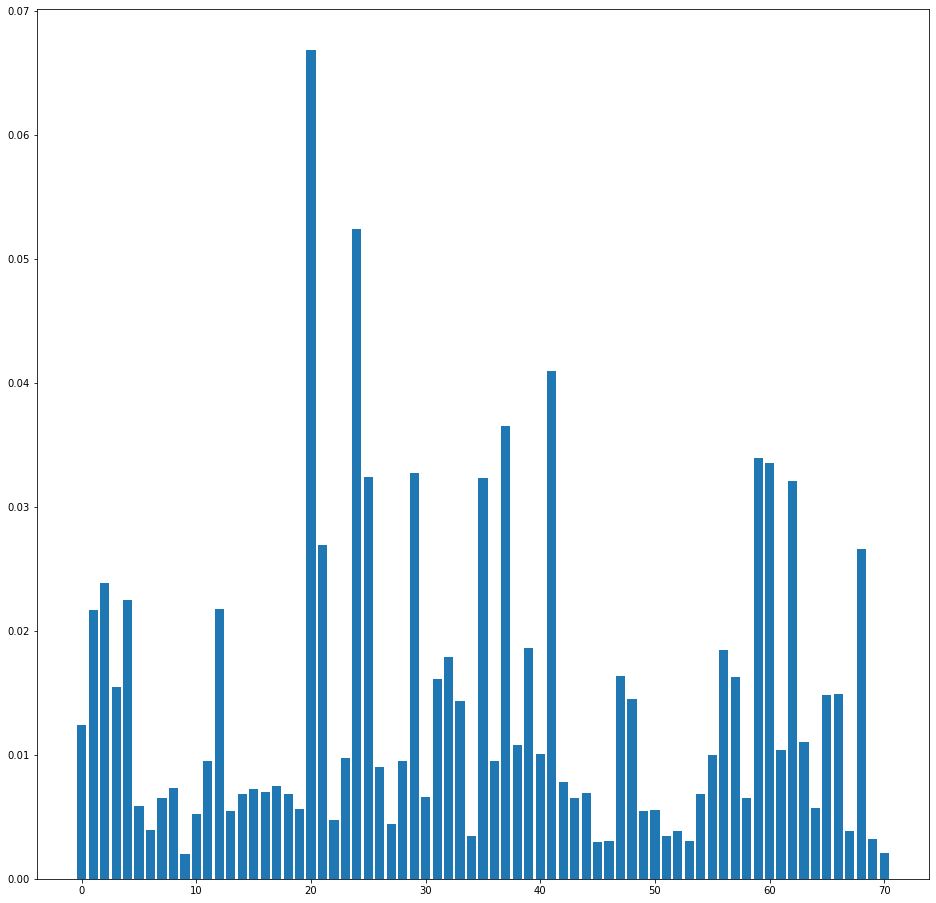

In [252]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,16))

ax.bar(x=list(range(pipe['model'].feature_importances_.shape[0])), height=pipe['model'].feature_importances_)

In [288]:
pipe['model'].feature_names_in_[-1]

'rnd_col'

In [289]:
pipe['model'].feature_importances_[-1]

0.0029201939723685123

In [292]:
pipe['model'].feature_importances_.shape

(71,)

In [293]:
(pipe['model'].feature_importances_ > pipe['model'].feature_importances_[-1]).sum()

66

In [295]:
pipe['model']

RandomForestClassifier(n_estimators=3, random_state=42)

In [296]:
pipe['model'].feature_importances_[(pipe['model'].feature_importances_ > pipe['model'].feature_importances_[-1])]

array([0.01418169, 0.0221464 , 0.02207083, 0.01780512, 0.00452911,
       0.00560549, 0.00299855, 0.00819803, 0.00753855, 0.00698074,
       0.00916008, 0.01270111, 0.00529066, 0.0046979 , 0.00642295,
       0.00635096, 0.01114628, 0.0090068 , 0.0046955 , 0.06558712,
       0.03132892, 0.00555986, 0.01202853, 0.04025051, 0.03422631,
       0.00919084, 0.00691489, 0.00955342, 0.03415709, 0.00682977,
       0.01592252, 0.02136911, 0.01600863, 0.00341232, 0.02975209,
       0.00737693, 0.03587402, 0.010596  , 0.01643401, 0.01223592,
       0.04147914, 0.00875445, 0.00487527, 0.00578339, 0.01863933,
       0.01785029, 0.00489018, 0.00903784, 0.00335393, 0.00592997,
       0.00617879, 0.00770919, 0.02383507, 0.0089274 , 0.00647622,
       0.04150908, 0.03391194, 0.01098168, 0.031299  , 0.01011324,
       0.00512313, 0.01129894, 0.01400538, 0.02135657, 0.02192834,
       0.00613824])

In [298]:
SIG_FEATURES=pipe['model'].feature_names_in_[(pipe['model'].feature_importances_ > pipe['model'].feature_importances_[-1])]
SIG_FEATURES

array(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-28', 'nd_mean_2021-04-29', 'nd_mean_2021-04-30',
       'nd_mean_2021-05-01', 'nd_mean_2021-05-02', 'nd_mean_2021-05-03',
       'nd_mean_2021-05-04', 'nd_mean_2021-05-07', 'nd_mean_2021-05-08',
       'nd_mean_2021-05-09', 'nd_mean_2021-05-10', 'nd_mean_2021-05-15',
       'nd_mean_2021-05-16', 'nd_mean_2021-05-17', 'nd_mean_2021-05-19',
       'nd_mean_2021-05-20', 'nd_mean_2021-05-21', 'nd_mean_2021-05-24',
       'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29',
       'nd_mean_2021-06-02', 'nd_mean_2021-06-03', 'nd_mean_2021-06-04',
       'nd_mean_2021-06-05', 'nd_mean_2021-06-06', 'nd_mean_2021-06-07',
       'nd_mean_2021-06-09', 'nd_mean_2021-06-10', 'nd_mean_2021-06-12',
       'nd_mean_2021-06-13', 'nd_mean_2021-06-16', 

<AxesSubplot:>

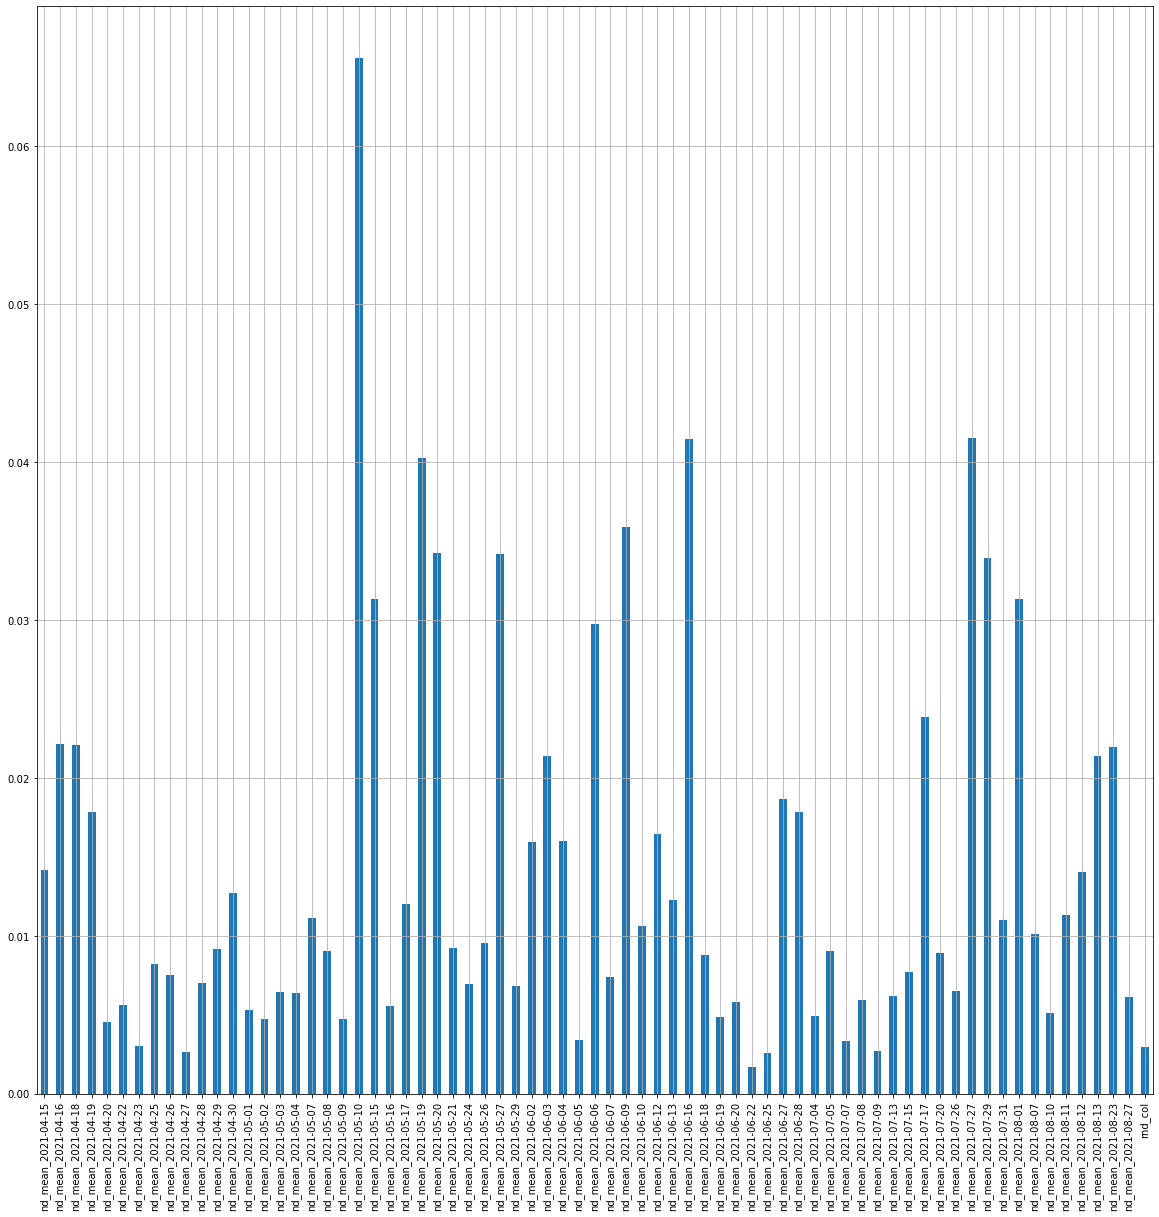

In [287]:
(pd.Series(pipe['model'].feature_importances_, index=pipe['model'].feature_names_in_)
   #.nlargest(50)
   .plot(kind='bar', figsize=(20,20), grid=True))  

In [255]:
X_train.columns + pd.Index('rnd_val')

TypeError: Index(...) must be called with a collection of some kind, 'rnd_val' was passed

In [58]:
pipe

Pipeline(steps=[('nan_masker',
                 NanMaskEncoder(features=Index(['nd_mean_2021-04-15', 'nd_mean_2021-04-16', 'nd_mean_2021-04-18',
       'nd_mean_2021-04-19', 'nd_mean_2021-04-20', 'nd_mean_2021-04-22',
       'nd_mean_2021-04-23', 'nd_mean_2021-04-25', 'nd_mean_2021-04-26',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-28', 'nd_mean_2021-04-29',
       'nd_mean_2021-04-30', 'nd_mean_2021-05...
       'nd_mean_2021-07-20', 'nd_mean_2021-07-26', 'nd_mean_2021-07-27',
       'nd_mean_2021-07-29', 'nd_mean_2021-07-31', 'nd_mean_2021-08-01',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-10', 'nd_mean_2021-08-11',
       'nd_mean_2021-08-12', 'nd_mean_2021-08-13', 'nd_mean_2021-08-23',
       'nd_mean_2021-08-27'],
      dtype='object'))),
                ('model',
                 CustomLightGBMClassifier(n_estimators=3, random_state=42))])

In [59]:
pipe['model'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 3,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# Перевод LightGBM в Pipeline

In [ ]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import lightgbm as ltb

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, r2_score, precision_score

def lgbm_clf(df_train_, df_test_, save_file_prefix='lgbm_solution'):
    X_ = df_train_.drop(["id",".geo", "crop"], axis = 1)
    y_ = df_train_[["crop"]]


    #Разделение на train/test для локального тестирования
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.20, random_state=1)
    
    # Обучение на части данных для оценки точности модели
    model_frac = ltb.LGBMClassifier()
    
    model_frac.fit(X_train_, y_train_)
    y_pred_frac = model_frac.predict(X_test_)
    
    #На локальном тестировании модель выдаёт такой результат
    result_frac = recall_score(y_test_, y_pred_frac, average='macro', zero_division=True)

    print("Recall score",result_frac)
    
    # Обучение на всех данных для предсказания на отправку
    model = ltb.LGBMClassifier()
    model.fit(X_, y_)
    
    y_pred_all = model.predict(df_test_.drop(['id', '.geo'], axis=1))
    
    #Сохраняем в csv файл
    pd.DataFrame({'id': df_test_.id,
                  'crop': np.squeeze(y_pred_all.astype(int))}).to_csv(
                    f'/kaggle/working/{save_file_prefix}_lgbm_full_out.csv', sep=',', index=None)

# Meta Labeling and Stacking

In [498]:
# @link https://towardsdatascience.com/meta-labeling-and-stacking-f17a7f9804ec

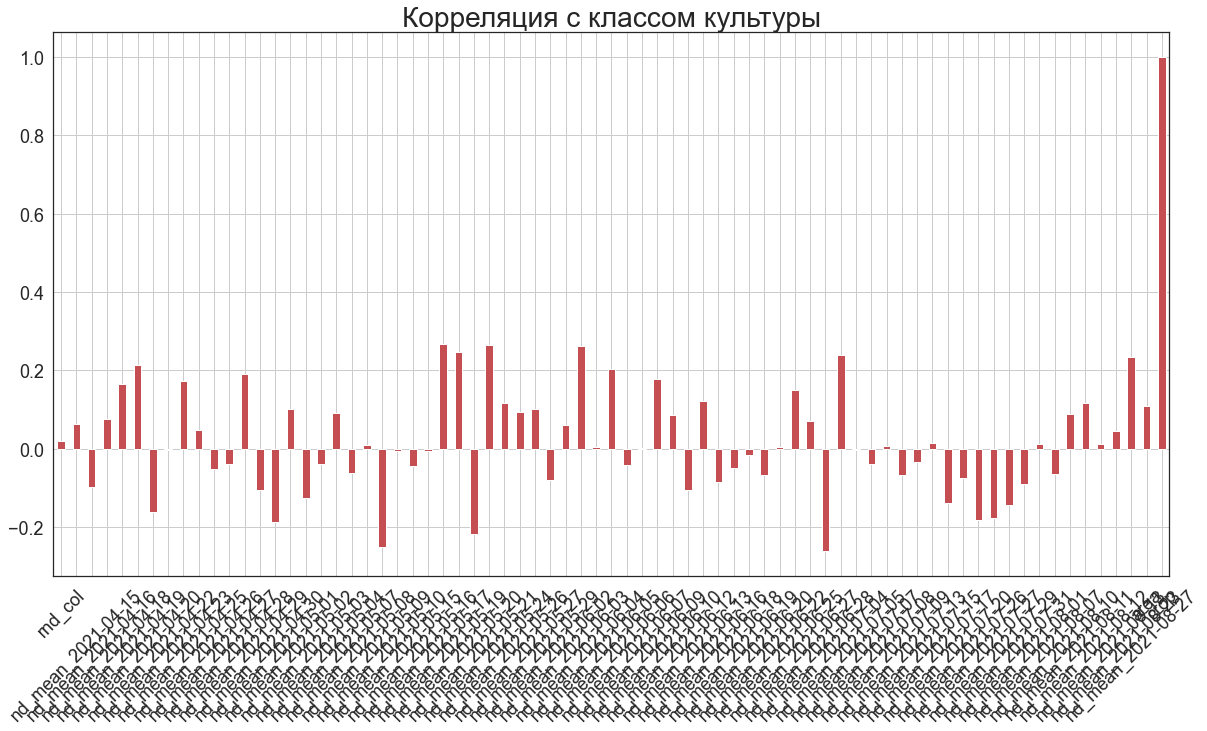

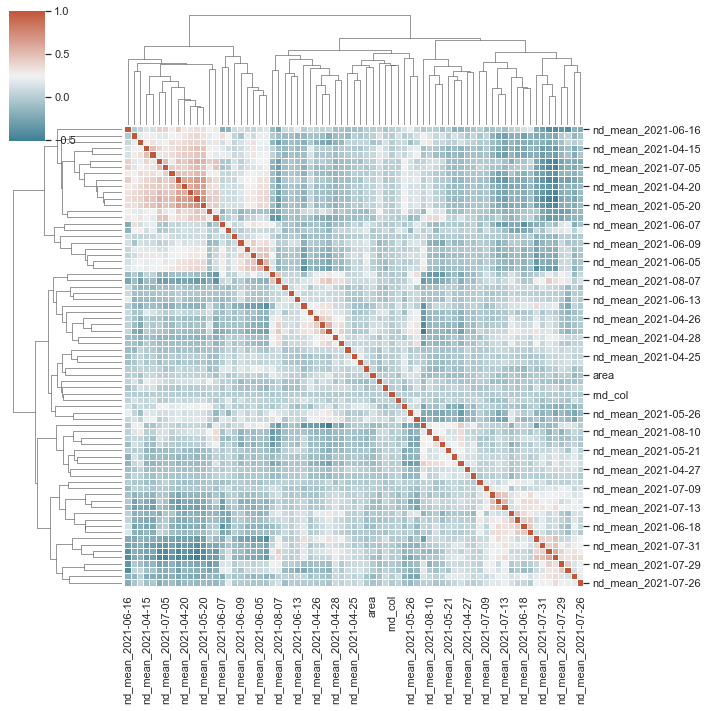

In [528]:
#see the cluster and corralation of features and classes
def plot_corr(data = df_train):
   
    ax1 = data.corrwith(data.crop).plot.bar(figsize = (20, 10),
         title = "Корреляция с классом культуры",
         fontsize = 18, color='r',
         rot = 45, grid = True)
    ax1.title.set_size(28)
    
    sns.set(style="white")
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    corr =data.corr()
    sns.clustermap(corr,cmap=cmap,
                  linewidths=1,linecolor='w')


rnd_col = pd.Series(np.random.random_sample(df_train.shape[0]), name='rnd_col')

df_train_ = pd.concat([rnd_col, df_train[TIME_SERIES], df_train[['area', 'crop']]], axis=1)

plot_corr(df_train_)


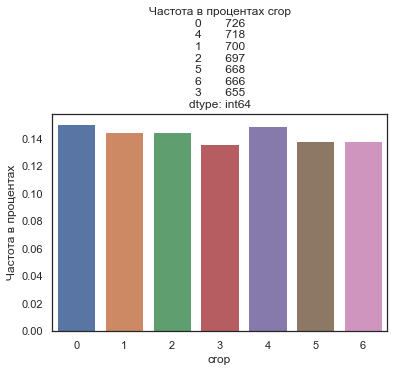

In [527]:
val_counts = df_train[['crop']].value_counts()

index_val = [idx[0] for idx in val_counts.index]

ax = sns.barplot(x=index_val,
                 y=val_counts/df_train.shape[0])

ax.set(title=f'Частота в процентах {val_counts}',
       xlabel='crop',
       ylabel='Частота в процентах');

In [544]:
from sklearn.metrics import average_precision_score, roc_curve, accuracy_score

# NOTE: for binary classification
def metrics_summary(true_label, prediction_prob, Threshold=0.5):
    
    #basically, slearn provides all the functions for metrics.
    #average_precision = average_precision_score(true_label
    #,prediction_prob)
    #fpr, tpr, thresholds = roc_curve(true_label, prediction_prob)
    #areaUnderROC = auc(fpr, tpr)
    
    prediction_int = prediction_prob > Threshold
    
    accuracy = accuracy_score(true_label, prediction_int)
            
    print(f'accuracy: {accuracy}')
    print(f"average_precision: {average_precision}")
    print(f'areaUnderROC: {areaUnderROC } \n')
    print('*'*60)
    print(' '*20, 'classification_report')
    print('*'*60, "\n")
    print(classification_report(true_label, prediction_int))
    
    print('*'*60)
    print(' '*20, 'confusion_matrix \n')
    print('*'*60, "\n")
    display(confusion_matrix(true_label, prediction_int))
    print("\n")
    
    # precision_recall_curve and areaUnderROC 
    precision, recall, thresholds = precision_recall_curve( \
                                true_label, prediction_int)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
    
    ax1.step(recall, precision, color='k', alpha=0.7, where='post')
    ax1.fill_between(recall, precision, step='post', 
    alpha=0.3,color='k')
    ax1.set_xlabel('Recall', fontname="Arial", fontsize=24)
    ax1.set_ylabel('Precision', fontname="Arial", fontsize=24) 
    ax1.tick_params(labelsize=20)
     
    ax1.set_title('Precision-Recall curve: Average Precision \
    = {0:0.2f}'.format(average_precision), fontsize=24,
    fontname="Arial")        
               
    ax2.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    ax2.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    ax2.tick_params(labelsize=20)
    ax2.set_xlabel('False Positive Rate', fontname="Arial",
    fontsize=24)
    ax2.set_ylabel('True Positive Rate', fontname="Arial",
    fontsize=24)
    ax2.set_title('areaUnderROC = {0:0.2f}'\
            .format(areaUnderROC), fontsize=24, fontname="Arial",)    
    ax2.legend(loc="lower right", fontsize=24, fancybox=True) 
    # Adjust the subplot layout, because the logit one may take 
    # more space
    # than usual, due to y-tick labels like "1 - 10^{-3}"
    # plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10,
    # right=0.95, hspace=0.25,wspace=0.35)

In [545]:
metrics_summary(y_train, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [112, 2071]

# XGBoost with Scikit-Learn Pipeline & GridSearchCV

In [546]:
# @link https://www.kaggle.com/code/carlosdg/xgboost-with-scikit-learn-pipeline-gridsearchcv
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [569]:
X_train, X_test, y_train, y_test = train_test_split(df_train[TS_AREA],
                                                    df_train[TARGET], 
                                                    test_size=0.2, random_state=SEED)

In [570]:
model = xgb.XGBClassifier()

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()), 
    #('pca', PCA()), 
    ('model', model)
])

param_grid = {
    #'pca__n_components': [5, 10, 15, 20, 25, 30],
    #'pca__n_components': [4],
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500],
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

In [571]:
%%time

grid.fit(X_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
D:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:02:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5min 28s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=Non...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [2, 3, 5, 7, 10],
                         'model__n_estimators': [10, 100, 500]},
             scoring='roc_auc')

In [572]:
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
std_score = grid.cv_results_["std_test_score"][grid.best_index_]

grid.best_params_, mean_score, std_score

print(f"Best parameters: {grid.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: {'model__max_depth': 2, 'model__n_estimators': 10}
Mean CV score:  nan
Standard deviation of CV score:  nan


In [578]:
#print(grid.cv_results_)
print(grid)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard_scaler', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
               

In [574]:
grid.predict(X_test)

array([0, 3, 3, 1, 1, 6, 5, 2, 3, 5, 0, 1, 1, 5, 4, 2, 4, 5, 5, 3, 5, 1,
       6, 6, 1, 5, 4, 3, 5, 1, 6, 6, 0, 3, 6, 2, 2, 4, 2, 0, 2, 6, 5, 5,
       2, 1, 3, 1, 1, 2, 4, 0, 1, 3, 2, 1, 1, 0, 3, 6, 4, 6, 1, 5, 6, 0,
       1, 5, 2, 6, 3, 0, 2, 3, 3, 6, 5, 3, 1, 3, 5, 6, 1, 3, 1, 5, 1, 5,
       6, 6, 6, 3, 2, 6, 1, 6, 6, 6, 1, 0, 0, 1, 6, 0, 6, 0, 5, 3, 1, 2,
       1, 5, 0, 0, 5, 6, 6, 0, 4, 6, 5, 5, 1, 2, 3, 1, 1, 3, 2, 6, 2, 2,
       5, 2, 4, 1, 3, 1, 3, 2, 6, 5, 5, 1, 6, 0, 0, 2, 0, 5, 5, 2, 5, 2,
       5, 2, 6, 0, 6, 3, 5, 4, 5, 6, 4, 3, 4, 0, 6, 6, 3, 2, 1, 5, 0, 4,
       1, 0, 0, 3, 2, 1, 5, 4, 3, 4, 4, 6, 2, 3, 6, 2, 3, 4, 5, 0, 5, 5,
       1, 1, 0, 4, 3, 1, 6, 0, 3, 5, 5, 3, 6, 0, 2, 0, 0, 1, 5, 0, 0, 3,
       0, 6, 4, 1, 0, 6, 1, 1, 1, 2, 2, 3, 3, 3, 2, 4, 1, 2, 2, 3, 1, 5,
       4, 2, 0, 3, 0, 3, 2, 5, 2, 4, 1, 1, 1, 4, 6, 3, 5, 3, 2, 2, 1, 2,
       1, 2, 6, 1, 2, 1, 1, 0, 2, 0, 1, 1, 1, 4, 2, 2, 6, 5, 4, 6, 4, 6,
       6, 4, 2, 4, 2, 4, 4, 2, 1, 5, 1, 2, 6, 1, 3,

In [575]:
y_test

746     0
1550    3
4528    3
3749    1
3848    1
       ..
4051    3
180     3
3830    1
432     0
2851    3
Name: crop, Length: 966, dtype: int64

In [576]:
print('\n',recall_score(grid.predict(X_test), y_test, average="macro", zero_division=0))


 0.9037275979287358


In [577]:
X_train.shape

(3864, 71)

  # LGBM Grid Search

In [640]:
# @link https://www.kaggle.com/code/bitit1994/parameter-grid-search-lgbm-with-scikit-learn/notebook
import numpy as np
import pandas as pd
from time import gmtime, strftime
import gc

from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import (roc_curve, auc, accuracy_score)

In [1121]:
params = {
    'application': 'multiclass', # for binary classification
#     'num_class' : 1, # used for multi-classes
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'device': 'cpu', # you can use GPU to achieve faster learning
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'multi_logloss',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

# Initiate classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'multiclass', 
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'])

# To view the default model parameters:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin'])

In [1122]:
gridParams = {
    #'learning_rate': [0.005, 0.01],
    'learning_rate': [0.01],
    #'n_estimators': [8,16,24],
    'n_estimators': [52, 58, 64],
    #'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'num_leaves': [12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['multiclass'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [SEED],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(df_train[TIME_SERIES], df_train[TARGET])

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 864 candidates, totalling 3456 fits


D:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 64, 'num_leaves': 16, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1.2, 'subsample': 0.7}
0.9482401567566677


In [1123]:
grid_search_best_params = {'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 64, 'num_leaves': 16, 'objective': 'multiclass', 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1.2, 'subsample': 0.7}

In [1199]:
gbm_params = grid_search_best_params
gbm_params['n_estimators']=256
gbm_params['max_bin']=1024

mdl = LGBMClassifier(**gbm_params)
mdl.fit(X_train, y_train)

y_pred = mdl.predict(X_test)
print('\n',recall_score(y_test, y_pred, average="macro", zero_division=0))


 0.9612368640726819


In [1200]:
mdl.fit(df_train[TIME_SERIES], df_train[TARGET])

LGBMClassifier(colsample_bytree=0.65, learning_rate=0.01, max_bin=1024,
               n_estimators=256, num_leaves=16, objective='multiclass',
               random_state=42, reg_alpha=1, reg_lambda=1.2, subsample=0.7)

In [1201]:
y_pred = mdl.predict(df_test[TIME_SERIES])

In [1202]:
# < 0.97
pd.DataFrame({'id': df_test.id,
              'crop': np.squeeze(y_sub.astype(int))}).to_csv(
    f'{OUT_DIR}lgbm_grid_search.3.csv', sep=',', index=None)

In [1255]:
from sklearn import linear_model
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline

In [1262]:
scores = cross_val_score(mdl, X_train, y_train, cv=StratifiedKFold(n_splits=5))

In [1263]:
scores

array([0.95472186, 0.96119017, 0.96119017, 0.95601552, 0.96243523])

In [1264]:
np.mean(scores)

0.959110591263431